# Mix EMA & Couple candlesticks & Momentum - Strategy - Backtesting 

In [1]:
# Giu nguyen Rule Long-Short cu, optimize QTY

### Import Library

In [71]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)
# from backtesting import set_bokeh_output
# set_bokeh_output(notebook=False)

### Load Price Data

In [3]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [4]:
data = dataset.copy()

In [5]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [6]:
data

Open    High     Low   Close  Volume
Date                                                       
2020-11-02 09:00:00   900.1   900.2   899.3   900.1    1910
2020-11-02 09:05:00   900.2   900.2   898.7   899.4    1670
2020-11-02 09:10:00   899.5   900.0   899.0   899.5    1329
2020-11-02 09:15:00   899.4   899.5   898.2   898.6    1722
2020-11-02 09:20:00   898.5   898.6   896.5   898.2    2939
...                     ...     ...     ...     ...     ...
2025-02-07 14:15:00  1343.3  1344.4  1342.4  1344.2    5075
2025-02-07 14:20:00  1344.2  1344.7  1343.6  1344.0    4865
2025-02-07 14:25:00  1344.1  1344.2  1342.8  1343.3    5013
2025-02-07 14:30:00  1343.3  1343.3  1343.3  1343.3     107
2025-02-07 14:45:00  1343.3  1343.3  1343.3  1343.3    6047

[54227 rows x 5 columns]

In [7]:
def get_ema_signal(r):
    signal = ''
    if r['ema_fast_s1'] < r['ema_low_s1'] and r['ema_fast'] > r['ema_low']:
        signal = 'long'
    elif r['ema_fast_s1'] > r['ema_low_s1'] and r['ema_fast'] < r['ema_low']:
        signal = 'short'
    return signal

In [8]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond


def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] == r['Low'] and r['Low'] < r['low_s1']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] == r['High'] and r['High'] > r['high_s1']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond
    

def get_couple_candleticks_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [9]:
def cal_signal(row):
    signal = ''
    if not row['first_close']:
        return signal
    if row['Close'] - row['prev_low'] > 21 or row['prev_high'] - row['Close'] > 21:
        return signal
    if row['mom_y'] > 0.26 and row['body_rate'] > .65:
        signal = 'long'
    elif row['mom_y'] < -.18 and row['body_rate'] < -.39:
        signal = 'short'
    return signal


def cal_first_close(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 915]
    if not tick.empty:
        return tick[0]


def cal_high_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1345]
    return tick.max()


def cal_low_before(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute < 1355]
    return tick.min()


def cal_last(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1445]
    if not tick.empty:
        return tick[0]

def cal_price(tick):
    tick = tick[100 * tick.index.hour + tick.index.minute == 1355]
    if not tick.empty:
        return tick[0]
        
def get_day_data(htd):
    data_tmp = htd.copy()
    data_tmp['first_close'] = data_tmp.Close
    data_tmp['_2pm_price'] = data_tmp.Close
    data_tmp['_last'] = data_tmp.Close
    data_tmp['prev_high'] = data_tmp.High
    data_tmp['prev_low'] = data_tmp.Low
    day_data = data_tmp.resample("D").agg({
        'first_close': cal_first_close,
        'prev_high': cal_high_before,
        'prev_low': cal_low_before,
        '_2pm_price': cal_price,
        '_last': cal_last
    }).rename(columns={'_last': 'day_Close'})
    day_data.dropna(subset=['day_Close'], inplace=True)
    day_data['prev_day_Close'] = day_data['day_Close'].shift(1)
    day_data.drop(columns=['day_Close'], inplace=True)
    return day_data[['prev_day_Close', 'first_close', 'prev_high', 'prev_low']]

def add_momentum_signal(data):
    clone_data = data.copy()
    day_data = get_day_data(clone_data)
    clone_data = clone_data.assign(time_d=pd.PeriodIndex(clone_data.index, freq='1D').to_timestamp())
    df_merged = pd.merge(clone_data, day_data, left_on="time_d", right_index=True, how="left")
    # df_merged = clone_data.merge(day_data, how='left', left_index=True, right_index=True)
    df_merged['mom_y'] = df_merged.apply(lambda r: 100 * (r['Close'] - r['prev_day_Close']) / r['prev_day_Close'] if r['first_close'] else 0, axis=1)
    df_merged['body_rate'] = df_merged.apply(lambda r: (r['Close'] - r['first_close']) / (r['prev_high'] - r['prev_low']) if r['first_close'] else 0, axis=1)
    df_merged['momentum_signal'] = df_merged.apply(lambda r: cal_signal(r), axis=1)
    df_merged.loc[100 * df_merged.index.hour + df_merged.index.minute != 1355, 'momentum_signal'] = ''
    return df_merged
    

In [10]:
def prepare_data(data):
    data["current"] = data.index + pd.DateOffset(minutes=5)
    # EMA signal
    data['max_in_range'] = data['High'].rolling(10).max()
    data['min_in_range'] = data['Low'].rolling(10).min()
    data["ema_superfast"] = ta.ema(data["Close"], length=10)
    data["ema_fast"] = ta.ema(data["Close"], length=20)
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['ema_fast_s1'] = data['ema_fast'].shift(1)
    data['ema_low_s1'] = data['ema_low'].shift(1)
    data['ema_signal'] = data.apply(lambda r: get_ema_signal(r), axis=1)
    # Couple candlesticks signal
    data['low_s1'] = data['Low'].shift(1)
    data['high_s1'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['couple_cs_signal'] = data.apply(lambda r: get_couple_candleticks_signal(r), axis=1)
    # Momentum signal
    data = add_momentum_signal(data)
    # Optimnize
    data['Close_s1'] = data['Close'].shift(1)
    data['RSI_14'] = ta.rsi(data["Close"], length=14)
    data['RSI_20'] = ta.rsi(data["Close"], length=20)
    data["ATR_14"] = ta.atr(data['High'], data['Low'], data['Close'], length=14)
    data["ATR_20"] = ta.atr(data['High'], data['Low'], data['Close'], length=20)
    data['body'] = data.apply(lambda r: abs(r['Close'] - r['Open']), axis=1)
    data['ibs'] = data.apply(lambda x: (-10 if (x["High"] == x["Low"]) else 10 * (x["Close"] - x["Low"]) / (x["High"] - x["Low"])), axis=1)
    data["vol_20_mean"] = data["Volume"].rolling(20).mean()
    data["diff_vol_percent"] = (data["Volume"] - data["Volume"].shift(1)) * 100 / data["Volume"].shift(1)
    data["diff_vol_percent_v2"] = (data["Volume"] / data["vol_20_mean"])
    data["vol_20_mean_s1"] = data["vol_20_mean"].shift(1)
    data["vol_20_mean_s2"] = data["vol_20_mean"].shift(3)
    data["vol_20_mean_s3"] = data["vol_20_mean"].shift(5)
    data["vol_20_mean_s4"] = data["vol_20_mean"].shift(7)
    data["vol_20_mean_s5"] = data["vol_20_mean"].shift(9)
    macd = ta.macd(data['Close'], 26, 12, 9)
    data = data.assign(MACDh=macd['MACDh_12_26_9'])
    adx = ta.adx(data['High'], data['Low'], data['Close'], length = 50)
    data = data.assign(ADX=adx['ADX_50'])
    data['price_move'] = data.apply(lambda r: (r['Close'] - r['Close_s1']) - 0.5 * r['ATR_14'] , axis=1)
    return data

In [11]:
data

Open    High     Low   Close  Volume
Date                                                       
2020-11-02 09:00:00   900.1   900.2   899.3   900.1    1910
2020-11-02 09:05:00   900.2   900.2   898.7   899.4    1670
2020-11-02 09:10:00   899.5   900.0   899.0   899.5    1329
2020-11-02 09:15:00   899.4   899.5   898.2   898.6    1722
2020-11-02 09:20:00   898.5   898.6   896.5   898.2    2939
...                     ...     ...     ...     ...     ...
2025-02-07 14:15:00  1343.3  1344.4  1342.4  1344.2    5075
2025-02-07 14:20:00  1344.2  1344.7  1343.6  1344.0    4865
2025-02-07 14:25:00  1344.1  1344.2  1342.8  1343.3    5013
2025-02-07 14:30:00  1343.3  1343.3  1343.3  1343.3     107
2025-02-07 14:45:00  1343.3  1343.3  1343.3  1343.3    6047

[54227 rows x 5 columns]

In [12]:
prepared_data = prepare_data(data)
prepared_data.dropna(subset=['Close', 'ATR_20', 'RSI_20'],inplace=True)

In [13]:
prepared_data

Open    High     Low   Close  Volume  \
Date                                                          
2020-11-02 10:40:00   899.2   899.4   898.8   899.4    1652   
2020-11-02 10:45:00   899.4   900.2   896.7   897.9    3197   
2020-11-02 10:50:00   897.8   898.9   896.8   898.3    2997   
2020-11-02 10:55:00   898.0   898.3   897.2   897.3    1668   
2020-11-02 11:00:00   897.3   897.4   895.4   897.0    3418   
...                     ...     ...     ...     ...     ...   
2025-02-07 14:15:00  1343.3  1344.4  1342.4  1344.2    5075   
2025-02-07 14:20:00  1344.2  1344.7  1343.6  1344.0    4865   
2025-02-07 14:25:00  1344.1  1344.2  1342.8  1343.3    5013   
2025-02-07 14:30:00  1343.3  1343.3  1343.3  1343.3     107   
2025-02-07 14:45:00  1343.3  1343.3  1343.3  1343.3    6047   

                                current  max_in_range  min_in_range  \
Date                                                                  
2020-11-02 10:40:00 2020-11-02 10:45:00         901.5         898.6   
2020-11-02 10:45:00 2020-11-02 10:50:00         901.5         896.7   
2020-11-02 10:50:00 2020-11-02 10:55:00         901.5         896.7   
2020-11-02 10:55:00 2020-11-02 11:00:00         901.5         896.7   
2020-11-02 11:00:00 2020-11-02 11:05:00         901.5         895.4   
...                                 ...           ...           ...   
2025-02-07 14:15:00 2025-02-07 14:20:00        1347.4        1341.2   
2025-02-07 14:20:00 2025-02-07 14:25:00        1347.4        1342.0   
2025-02-07 14:25:00 2025-02-07 14:30:00        1347.4        1342.4   
2025-02-07 14:30:00 2025-02-07 14:35:00        1346.5        1342.4   
2025-02-07 14:45:00 2025-02-07 14:50:00        1346.5        1342.4   

                     ema_superfast     ema_fast  ...  diff_vol_percent  \
Date                                             ...                     
2020-11-02 10:40:00     899.678966   899.422619  ...         49.367089   
2020-11-02 10:45:00     899.355517   899.277608  ...         93.523002   
2020-11-02 10:50:00     899.163605   899.184502  ...         -6.255865   
2020-11-02 10:55:00     898.824768   899.005026  ...        -44.344344   
2020-11-02 11:00:00     898.492992   898.814071  ...        104.916067   
...                            ...          ...  ...               ...   
2025-02-07 14:15:00    1343.886991  1342.719356  ...        -22.766702   
2025-02-07 14:20:00    1343.907538  1342.841322  ...         -4.137931   
2025-02-07 14:25:00    1343.797076  1342.885006  ...          3.042138   
2025-02-07 14:30:00    1343.706699  1342.924529  ...        -97.865550   
2025-02-07 14:45:00    1343.632754  1342.960288  ...       5551.401869   

                     diff_vol_percent_v2  vol_20_mean_s1 vol_20_mean_s2  \
Date                                                                      
2020-11-02 10:40:00             0.919157         1810.20            NaN   
2020-11-02 10:45:00             1.706295         1797.30            NaN   
2020-11-02 10:50:00             1.531387         1873.65        1810.20   
2020-11-02 10:55:00             0.853481         1957.05        1797.30   
2020-11-02 11:00:00             1.727746         1954.35        1873.65   
...                                  ...             ...            ...   
2025-02-07 14:15:00             1.281291         3846.60        3458.35   
2025-02-07 14:20:00             1.184174         3960.85        3608.35   
2025-02-07 14:25:00             1.168368         4108.35        3846.60   
2025-02-07 14:30:00             0.025180         4290.60        3960.85   
2025-02-07 14:45:00             1.328894         4249.40        4108.35   

                     vol_20_mean_s3  vol_20_mean_s4  vol_20_mean_s5     MACDh  \
Date                                                                            
2020-11-02 10:40:00             NaN             NaN             NaN       NaN   
2020-11-02 10:45:00             NaN             NaN             NaN       NaN   
2020-11-02 10:50

In [14]:
backtest_data = prepared_data[['Open', 'Close', 'High', 'Low', 'min_in_range', 'max_in_range', 'min_5', 'max_5', 'ema_signal', 'momentum_signal', 'couple_cs_signal']]
backtest_data[(backtest_data.ema_signal != '') | (backtest_data.momentum_signal != '') | (backtest_data.couple_cs_signal != '')]

Open   Close    High     Low  min_in_range  \
Date                                                                
2020-11-02 14:25:00   904.9   907.0   907.0   904.5         896.6   
2020-11-03 09:20:00   908.5   908.1   908.8   908.1         897.4   
2020-11-04 09:35:00   907.8   907.3   908.0   907.3         907.3   
2020-11-04 10:05:00   908.2   909.0   909.0   908.1         906.7   
2020-11-04 10:15:00   910.2   911.5   911.5   909.8         906.7   
...                     ...     ...     ...     ...           ...   
2025-02-05 13:15:00  1332.2  1331.6  1332.5  1331.6        1331.0   
2025-02-05 13:25:00  1331.7  1330.9  1332.1  1330.9        1330.9   
2025-02-05 13:50:00  1331.9  1333.4  1333.4  1331.5        1329.6   
2025-02-06 09:55:00  1342.5  1344.3  1344.3  1342.3        1339.7   
2025-02-07 13:55:00  1345.0  1344.9  1345.0  1344.3        1337.8   

                     max_in_range   min_5   max_5 ema_signal momentum_signal  \
Date                                                                           
2020-11-02 14:25:00         907.0   896.6   907.0                              
2020-11-03 09:20:00         909.4   908.1   909.4                              
2020-11-04 09:35:00         909.9   907.3   908.8                              
2020-11-04 10:05:00         909.0   906.8   909.0                              
2020-11-04 10:15:00         911.5   907.6   911.5                              
...                           ...     ...     ...        ...             ...   
2025-02-05 13:15:00        1333.4  1331.5  1332.6                              
2025-02-05 13:25:00        1332.6  1330.9  1332.6                              
2025-02-05 13:50:00        1333.4  1329.6  1333.4                              
2025-02-06 09:55:00        1344.3  1341.2  1344.3                              
2025-02-07 13:55:00        1347.4  1342.0  1347.4                       long   

                    couple_cs_signal  
Date                                  
2020-11-02 14:25:00             long  
2020-11-03 09:20:00            short  
2020-11-04 09:35:00            short  
2020-11-04 10:05:00             long  
2020-11-04 10:15:00             long  
...                              ...  
2025-02-05 13:15:00            short  
2025-02-05 13:25:00            short  
2025-02-05 13:50:00             long  
2025-02-06 09:55:00             long  
2025-02-07 13:55:00                   

[2946 rows x 11 columns]

In [15]:
backtest_data[backtest_data.momentum_signal != '']

Open   Close    High     Low  min_in_range  \
Date                                                                
2020-11-04 13:55:00   912.8   916.3   917.2   912.5         912.1   
2020-11-06 13:55:00   908.3   907.3   908.4   906.7         903.3   
2020-11-11 13:55:00   914.3   915.6   915.7   914.0         914.0   
2020-11-13 13:55:00   931.6   932.9   933.4   931.2         929.2   
2020-11-16 13:55:00   928.2   933.5   933.8   928.2         925.5   
...                     ...     ...     ...     ...           ...   
2025-01-10 13:55:00  1307.2  1309.3  1309.3  1306.2        1305.2   
2025-01-17 13:55:00  1312.9  1315.4  1316.7  1312.8        1309.6   
2025-01-21 13:55:00  1317.6  1319.4  1319.9  1317.6        1316.6   
2025-02-03 13:55:00  1317.4  1315.5  1318.3  1315.5        1315.5   
2025-02-07 13:55:00  1345.0  1344.9  1345.0  1344.3        1337.8   

                     max_in_range   min_5   max_5 ema_signal momentum_signal  \
Date                                                                           
2020-11-04 13:55:00         917.2   912.4   917.2                       long   
2020-11-06 13:55:00         908.6   903.5   908.6                      short   
2020-11-11 13:55:00         921.2   914.0   921.0                      short   
2020-11-13 13:55:00         933.4   929.2   933.4                       long   
2020-11-16 13:55:00         936.3   925.5   934.0                      short   
...                           ...     ...     ...        ...             ...   
2025-01-10 13:55:00        1310.4  1305.2  1309.3                      short   
2025-01-17 13:55:00        1316.7  1310.8  1316.7                       long   
2025-01-21 13:55:00        1324.4  1316.6  1320.3                      short   
2025-02-03 13:55:00        1321.9  1315.5  1321.0                      short   
2025-02-07 13:55:00        1347.4  1342.0  1347.4                       long   

                    couple_cs_signal  
Date                                  
2020-11-04 13:55:00                   
2020-11-06 13:55:00                   
2020-11-11 13:55:00                   
2020-11-13 13:55:00                   
2020-11-16 13:55:00                   
...                              ...  
2025-01-10 13:55:00                   
2025-01-17 13:55:00                   
2025-01-21 13:55:00                   
2025-02-03 13:55:00            short  
2025-02-07 13:55:00                   

[300 rows x 11 columns]

In [16]:
backtest_data

Open   Close    High     Low  min_in_range  \
Date                                                                
2020-11-02 10:40:00   899.2   899.4   899.4   898.8         898.6   
2020-11-02 10:45:00   899.4   897.9   900.2   896.7         896.7   
2020-11-02 10:50:00   897.8   898.3   898.9   896.8         896.7   
2020-11-02 10:55:00   898.0   897.3   898.3   897.2         896.7   
2020-11-02 11:00:00   897.3   897.0   897.4   895.4         895.4   
...                     ...     ...     ...     ...           ...   
2025-02-07 14:15:00  1343.3  1344.2  1344.4  1342.4        1341.2   
2025-02-07 14:20:00  1344.2  1344.0  1344.7  1343.6        1342.0   
2025-02-07 14:25:00  1344.1  1343.3  1344.2  1342.8        1342.4   
2025-02-07 14:30:00  1343.3  1343.3  1343.3  1343.3        1342.4   
2025-02-07 14:45:00  1343.3  1343.3  1343.3  1343.3        1342.4   

                     max_in_range   min_5   max_5 ema_signal momentum_signal  \
Date                                                                           
2020-11-02 10:40:00         901.5   898.8   901.2                              
2020-11-02 10:45:00         901.5   896.7   900.4                              
2020-11-02 10:50:00         901.5   896.7   900.4                              
2020-11-02 10:55:00         901.5   896.7   900.4                              
2020-11-02 11:00:00         901.5   895.4   900.2                              
...                           ...     ...     ...        ...             ...   
2025-02-07 14:15:00        1347.4  1342.4  1346.5                              
2025-02-07 14:20:00        1347.4  1342.4  1346.5                              
2025-02-07 14:25:00        1347.4  1342.4  1346.5                              
2025-02-07 14:30:00        1346.5  1342.4  1345.2                              
2025-02-07 14:45:00        1346.5  1342.4  1344.7                              

                    couple_cs_signal  
Date                                  
2020-11-02 10:40:00                   
2020-11-02 10:45:00                   
2020-11-02 10:50:00                   
2020-11-02 10:55:00                   
2020-11-02 11:00:00                   
...                              ...  
2025-02-07 14:15:00                   
2025-02-07 14:20:00                   
2025-02-07 14:25:00                   
2025-02-07 14:30:00                   
2025-02-07 14:45:00                   

[54207 rows x 11 columns]

In [17]:
class MainStrategy(Strategy):
    max_sl = 3.5
    #
    ema_trailing_sl = 5.5
    ema_tp_step = 27
    #
    momentum_trailing_sl = 4.5
    momentum_tp_step = 27
    #
    cs_trailing_sl = 7.5
    cs_tp_step = 27
    #
    def init(self):
        self._broker._cash = 1500
        self.strategy = ''
        super().init()

    def next(self):
        super().next()
        close_price = self.data.Close[-1]
        # Strategy trailing stoploss
        if self.strategy == 'ema':
            if self.position.is_long:
                max_in_range = self.data.max_in_range[-1]
                if close_price < max_in_range - self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_in_range = self.data.min_in_range[-1]
                if close_price > min_in_range + self.ema_trailing_sl:
                    self.strategy = ''
                    self.position.close()
        elif self.strategy == 'couple_cs':
            if self.position.is_long:
                max_5 = self.data.max_5[-1]
                if close_price < max_5 - self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()
            elif self.position.is_short:
                min_5 = self.data.min_5[-1]
                if close_price > min_5 + self.cs_trailing_sl:
                    self.strategy = ''
                    self.position.close()

        # Close deal at 14:00
        if self.strategy == 'couple_cs' or self.strategy == 'momentum':
            _time = self.data.index
            current_time = _time[-1]
            if current_time.hour == 14 and current_time.minute >= 25:
                if self.position.is_long or self.position.is_short:
                    self.strategy = ''
                    self.position.close()
                return
            
        # Main Strategy
        ema_signal = self.data.ema_signal[-1]
        momentum_signal = self.data.momentum_signal[-1]
        couple_cs_signal = self.data.couple_cs_signal[-1]
        if self.position:
            # return
            if self.strategy != 'ema':
                if self.position.is_long and ema_signal == 'long':
                    self.strategy = 'ema'
                elif self.position.is_short and ema_signal == 'short':
                    self.strategy = 'ema'
        else:
            if ema_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.ema_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                self.strategy = 'ema'
            elif ema_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.ema_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'ema'
            elif momentum_signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.momentum_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                # print(f'sl: {sl}, tp: {tp}')
                self.strategy = 'momentum'
            elif momentum_signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.momentum_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'momentum'
                # print(f'sl: {sl}, tp: {tp}')
            elif couple_cs_signal == 'long':
                # print('couple_cs_signal')
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.cs_tp_step
                self.buy(size=1, sl=sl, tp=tp)
                self.strategy = 'couple_cs'
            elif couple_cs_signal == 'short':
                # print('couple_cs_signal2')
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.cs_tp_step
                self.sell(size=1, sl=sl, tp=tp)
                self.strategy = 'couple_cs'

In [18]:
bt = Backtest(backtest_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [19]:
stats

Start                     2020-11-02 10:40:00
End                       2025-02-07 14:45:00
Duration                   1558 days 04:05:00
Exposure Time [%]                   48.268674
Equity Final [$]                    2973.5509
Equity Peak [$]                    2983.25437
Return [%]                          98.236727
Buy & Hold Return [%]               49.355126
Return (Ann.) [%]                   17.649399
Volatility (Ann.) [%]                7.792127
Sharpe Ratio                          2.26503
Sortino Ratio                        5.342631
Calmar Ratio                         4.665192
Max. Drawdown [%]                   -3.783209
Avg. Drawdown [%]                   -0.306156
Max. Drawdown Duration      114 days 00:30:00
Avg. Drawdown Duration        3 days 01:32:00
# Trades                                 1623
Win Rate [%]                         37.58472
Best Trade [%]                       3.309918
Worst Trade [%]                     -0.910953
Avg. Trade [%]                    

In [20]:
stats['_trades'].tail(20)

Size  EntryBar  ExitBar  EntryPrice  ExitPrice       PnL  ReturnPct  \
1603    -1     53277    53287  1323.90271     1319.7   4.20271   0.003174   
1604     1     53294    53302  1318.19534     1314.2  -3.99534  -0.003031   
1605    -1     53304    53309  1311.90631     1315.7  -3.79369  -0.002892   
1606    -1     53353    53389  1321.20352     1311.9   9.30352   0.007042   
1607    -1     53418    53440  1311.00658     1295.6  15.40658   0.011752   
1608     1     53460    53465  1292.38760     1288.5  -3.88760  -0.003008   
1609     1     53484    53491  1295.18844     1298.0   2.81156   0.002171   
1610    -1     53496    53542  1295.01138     1290.2   4.81138   0.003715   
1611     1     53601    53616  1308.19234     1304.2  -3.99234  -0.003052   
1612    -1     53629    53646  1300.20982     1308.9  -8.69018  -0.006684   
1613     1     53650    53768  1309.49273     1324.8  15.30727   0.011689   
1614    -1     53791    53797  1318.70427     1321.3  -2.59573  -0.001968   
1615     1     53854    53899  1324.69729     1342.9  18.20271   0.013741   
1616     1     53922    53950  1340.60206     1342.1   1.49794   0.001117   
1617    -1     53964    53972  1318.60430     1319.5  -0.89570  -0.000679   
1618    -1     53995    54001  1314.90541     1315.7  -0.79459  -0.000604   
1619    -1     54011    54015  1321.50343     1325.3  -3.79657  -0.002873   
1620    -1     54024    54028  1321.90331     1325.8  -3.89669  -0.002948   
1621     1     54043    54157  1328.39840     1336.6   8.20160   0.006174   
1622     1     54199    54205  1345.30347     1343.3  -2.00347  -0.001489   

               EntryTime            ExitTime   Tag        Duration  
1603 2025-01-07 13:40:00 2025-01-07 14:30:00  None 0 days 00:50:00  
1604 2025-01-08 09:25:00 2025-01-08 10:05:00  None 0 days 00:40:00  
1605 2025-01-08 10:15:00 2025-01-08 10:40:00  None 0 days 00:25:00  
1606 2025-01-09 10:05:00 2025-01-09 14:30:00  None 0 days 04:25:00  
1607 2025-01-10 11:15:00 2025-01-10 14:30:00  None 0 days 03:15:00  
1608 2025-01-13 10:30:00 2025-01-13 10:55:00  None 0 days 00:25:00  
1609 2025-01-13 13:55:00 2025-01-13 14:30:00  None 0 days 00:35:00  
1610 2025-01-14 09:15:00 2025-01-14 14:30:00  None 0 days 05:15:00  
1611 2025-01-16 09:30:00 2025-01-16 10:45:00  None 0 days 01:15:00  
1612 2025-01-16 13:15:00 2025-01-17 09:00:00  None 0 days 19:45:00  
1613 2025-01-17 09:20:00 2025-01-21 10:40:00  None 4 days 01:20:00  
1614 2025-01-21 14:00:00 2025-01-21 14:30:00  None 0 days 00:30:00  
1615 2025-01-23 09:20:00 2025-01-23 14:30:00  None 0 days 05:10:00  
1616 2025-01-24 10:45:00 2025-01-24 14:30:00  None 0 days 03:45:00  
1617 2025-02-03 10:00:00 2025-02-03 10:40:00  None 0 days 00:40:00  
1618 2025-02-03 14:00:00 2025-02-03 14:30:00  None 0 days 00:30:00  
1619 2025-02-04 09:40:00 2025-02-04 10:00:00  None 0 days 00:20:00  
1620 2025-02-04 10:45:00 2025-02-04 11:05:00  None 0 days 00:20:00  
1621 2025-02-04 13:45:00 2025-02-07 09:05:00  None 2 days 19:20:00  
1622 2025-02-07 14:00:00 2025-02-07 14:30:00  None 0 days 00:30:00

In [21]:
stats['_trades']['PnL'].min()

-11.658729999999878

In [22]:
trades = stats['_trades']

In [23]:
trades[trades.EntryTime > '2024-01-01 00:00:00']['PnL'].sum()

265.93195000001424

In [24]:
trades[(trades.EntryTime > '2023-01-01 00:00:00') & (trades.EntryTime < '2024-01-01 00:00:00')]['PnL'].sum()

392.32576000000927

In [25]:
trades[(trades.EntryTime > '2022-01-01 00:00:00') & (trades.EntryTime < '2023-01-01 00:00:00')]['PnL'].sum()

516.079070000016

In [26]:
trades[trades.PnL < -3.1]

Size  EntryBar  ExitBar  EntryPrice  ExitPrice      PnL  ReturnPct  \
2       -1        90       97   907.02781      910.8 -3.77219  -0.004159   
11      -1       620      636   935.71920      939.6 -3.88080  -0.004147   
13      -1       700      729   946.91584      950.6 -3.68416  -0.003891   
15       1       813      825   962.28860      958.2 -4.08860  -0.004249   
16      -1       836      837   953.31392      957.5 -4.18608  -0.004391   
...    ...       ...      ...         ...        ...      ...        ...   
1608     1     53460    53465  1292.38760     1288.5 -3.88760  -0.003008   
1611     1     53601    53616  1308.19234     1304.2 -3.99234  -0.003052   
1612    -1     53629    53646  1300.20982     1308.9 -8.69018  -0.006684   
1619    -1     54011    54015  1321.50343     1325.3 -3.79657  -0.002873   
1620    -1     54024    54028  1321.90331     1325.8 -3.89669  -0.002948   

               EntryTime            ExitTime   Tag        Duration  
2    2020-11-04 09:40:00 2020-11-04 10:15:00  None 0 days 00:35:00  
11   2020-11-18 11:30:00 2020-11-18 14:15:00  None 0 days 02:45:00  
13   2020-11-20 09:40:00 2020-11-20 13:30:00  None 0 days 03:50:00  
15   2020-11-24 10:35:00 2020-11-24 13:00:00  None 0 days 02:25:00  
16   2020-11-24 13:55:00 2020-11-24 14:00:00  None 0 days 00:05:00  
...                  ...                 ...   ...             ...  
1608 2025-01-13 10:30:00 2025-01-13 10:55:00  None 0 days 00:25:00  
1611 2025-01-16 09:30:00 2025-01-16 10:45:00  None 0 days 01:15:00  
1612 2025-01-16 13:15:00 2025-01-17 09:00:00  None 0 days 19:45:00  
1619 2025-02-04 09:40:00 2025-02-04 10:00:00  None 0 days 00:20:00  
1620 2025-02-04 10:45:00 2025-02-04 11:05:00  None 0 days 00:20:00  

[821 rows x 11 columns]

In [27]:
trades[trades.PnL < -3.1]['PnL'].sum()

-3247.808599999968

In [28]:
len(trades[trades.PnL < -3.1]) * -3.1

-2545.1

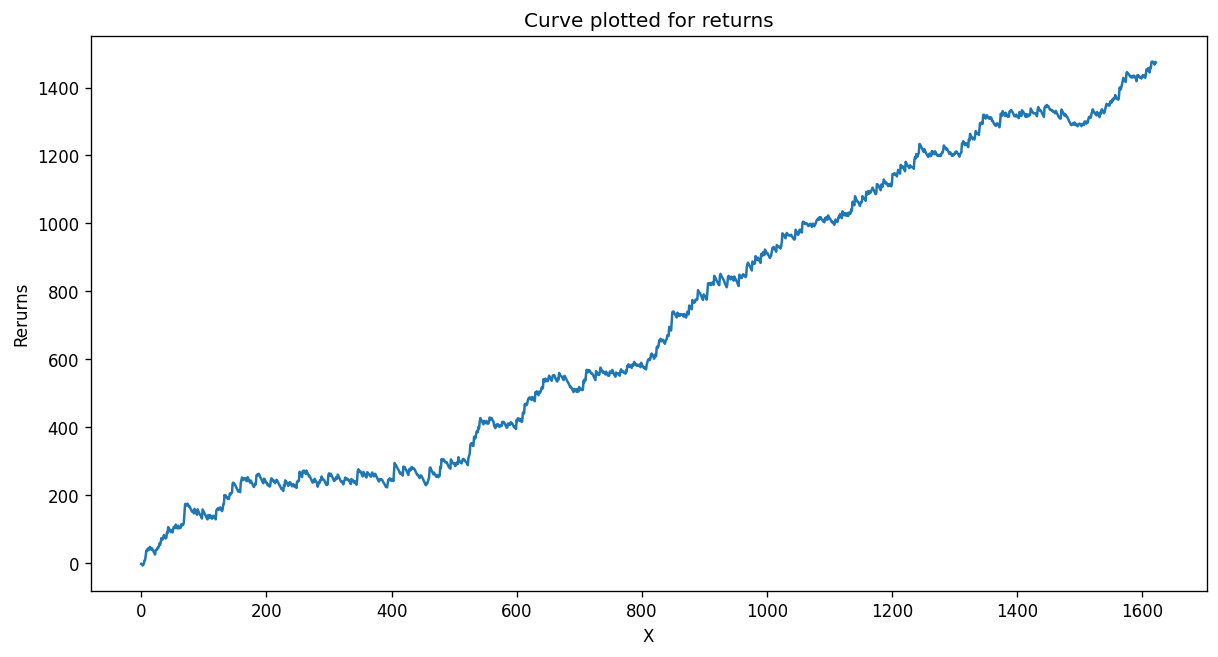

In [29]:
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [30]:
trades[trades.EntryTime > '2024-01-01 00:00:00']['PnL'].sum()

265.93195000001424

## Optimize profit

In [31]:
join_trades = pd.merge(trades, prepared_data, left_on="EntryTime", right_on='current', how="left")
join_trades.tail(30)

Size  EntryBar  ExitBar  EntryPrice  ExitPrice       PnL  ReturnPct  \
1593     1     52880    52886  1349.50473     1351.1   1.59527   0.001182   
1594    -1     52912    52937  1348.19542     1348.6  -0.40458  -0.000300   
1595    -1     52966    52984  1351.99428     1356.0  -4.00572  -0.002963   
1596    -1     53000    53039  1344.89641     1344.7   0.19641   0.000146   
1597     1     53056    53067  1351.70539     1347.6  -4.10539  -0.003037   
1598    -1     53097    53136  1348.19542     1345.8   2.39542   0.001777   
1599     1     53156    53160  1340.30197     1336.3  -4.00197  -0.002986   
1600    -1     53179    53185  1330.10085     1326.4   3.70085   0.002782   
1601    -1     53201    53236  1327.10175     1321.2   5.90175   0.004447   
1602    -1     53261    53269  1322.90301     1326.9  -3.99699  -0.003021   
1603    -1     53277    53287  1323.90271     1319.7   4.20271   0.003174   
1604     1     53294    53302  1318.19534     1314.2  -3.99534  -0.003031   
1605    -1     53304    53309  1311.90631     1315.7  -3.79369  -0.002892   
1606    -1     53353    53389  1321.20352     1311.9   9.30352   0.007042   
1607    -1     53418    53440  1311.00658     1295.6  15.40658   0.011752   
1608     1     53460    53465  1292.38760     1288.5  -3.88760  -0.003008   
1609     1     53484    53491  1295.18844     1298.0   2.81156   0.002171   
1610    -1     53496    53542  1295.01138     1290.2   4.81138   0.003715   
1611     1     53601    53616  1308.19234     1304.2  -3.99234  -0.003052   
1612    -1     53629    53646  1300.20982     1308.9  -8.69018  -0.006684   
1613     1     53650    53768  1309.49273     1324.8  15.30727   0.011689   
1614    -1     53791    53797  1318.70427     1321.3  -2.59573  -0.001968   
1615     1     53854    53899  1324.69729     1342.9  18.20271   0.013741   
1616     1     53922    53950  1340.60206     1342.1   1.49794   0.001117   
1617    -1     53964    53972  1318.60430     1319.5  -0.89570  -0.000679   
1618    -1     53995    54001  1314.90541     1315.7  -0.79459  -0.000604   
1619    -1     54011    54015  1321.50343     1325.3  -3.79657  -0.002873   
1620    -1     54024    54028  1321.90331     1325.8  -3.89669  -0.002948   
1621     1     54043    54157  1328.39840     1336.6   8.20160   0.006174   
1622     1     54199    54205  1345.30347     1343.3  -2.00347  -0.001489   

               EntryTime            ExitTime   Tag  ... diff_vol_percent  \
1593 2024-12-25 14:00:00 2024-12-25 14:30:00  None  ...        52.878020   
1594 2024-12-26 11:00:00 2024-12-26 14:30:00  None  ...        -2.094619   
1595 2024-12-27 11:15:00 2024-12-27 14:10:00  None  ...        13.678516   
1596 2024-12-30 09:50:00 2024-12-30 14:30:00  None  ...        55.887850   
1597 2024-12-31 10:15:00 2024-12-31 11:10:00  None  ...       243.172952   
1598 2025-01-02 10:00:00 2025-01-03 09:00:00  None  ...       -25.488632   
1599 2025-01-03 10:40:00 2025-01-03 11:00:00  None  ...        19.580878   
1600 2025-01-03 14:00:00 2025-01-03 14:30:00  None  ...        32.431551   
1601 2025-01-06 10:10:00 2025-01-06 14:30:00  None  ...       -28.645588   
1602 2025-01-07 10:55:00 2025-01-07 13:00:00  None  ...       -15.579399   
1603 2025-01-07 13:40:00 2025-01-07 14:30:00  None  ...       -31.968979   
1604 2025-01-08 09:25:00 2025-01-08 10:05:00  None  ...       -51.425314   
1605 2025-01-08 10:15:00 2025-01-08 10:40:00  None  ...       -27.874071   
1606 2025-01-09 10:05:00 2025-01-09 14:30:00  None  ...         6.344629   
1607 2025-01-10 11:15:00 2025-01-10 14:30:00  None  ...        36.664321   
1608 2025-01-13 10:30:00 2025-01-13 10:55:00  None  ...        15.830389   
1609 2025-01-13 13:55:00 2025-01-13 14:30:00  None  ...       -45.328796   
1610 2025-01-14 09:15:00 2025-01-14 14:30:00  None  ...        88.338602   
1611 2025-01-16 09:30:00 2025-01-16 10:45:00  None  ...       -43.811283   
1612 2025-01-16 13:15:00 2025-01-17 09:00:00  None  ...        13.026572   
1613 2025-01-17 09:20:

In [32]:
join_trades[join_trades.EntryTime == '2020-11-04 10:20:00'].iloc[-1]

Size                                     1
EntryBar                                98
ExitBar                                131
EntryPrice                       912.07354
ExitPrice                            913.5
PnL                                1.42646
ReturnPct                         0.001564
EntryTime              2020-11-04 10:20:00
ExitTime               2020-11-04 14:30:00
Tag                                   None
Duration                   0 days 04:10:00
Open                                 910.2
High                                 911.5
Low                                  909.8
Close                                911.5
Volume                              3514.0
current                2020-11-04 10:20:00
max_in_range                         911.5
min_in_range                         906.7
ema_superfast                   909.034944
ema_fast                        908.496116
ema_low                                NaN
ema_fast_s1                     908.179917
ema_low_s1 

In [33]:
prepared_data[prepared_data.index == '2020-11-04 10:15:00'].iloc[-1]

Open                                 910.2
High                                 911.5
Low                                  909.8
Close                                911.5
Volume                                3514
current                2020-11-04 10:20:00
max_in_range                         911.5
min_in_range                         906.7
ema_superfast                   909.034944
ema_fast                        908.496116
ema_low                                NaN
ema_fast_s1                     908.179917
ema_low_s1                             NaN
ema_signal                                
low_s1                               909.1
high_s1                              910.5
max_5                                911.5
min_5                                907.6
condition_1                           long
condition_2                           long
couple_cs_signal                      long
time_d                 2020-11-04 00:00:00
prev_day_Close                       908.3
first_close

In [34]:
join_trades.columns

Index(['Size', 'EntryBar', 'ExitBar', 'EntryPrice', 'ExitPrice', 'PnL',
       'ReturnPct', 'EntryTime', 'ExitTime', 'Tag', 'Duration', 'Open', 'High',
       'Low', 'Close', 'Volume', 'current', 'max_in_range', 'min_in_range',
       'ema_superfast', 'ema_fast', 'ema_low', 'ema_fast_s1', 'ema_low_s1',
       'ema_signal', 'low_s1', 'high_s1', 'max_5', 'min_5', 'condition_1',
       'condition_2', 'couple_cs_signal', 'time_d', 'prev_day_Close',
       'first_close', 'prev_high', 'prev_low', 'mom_y', 'body_rate',
       'momentum_signal', 'Close_s1', 'RSI_14', 'RSI_20', 'ATR_14', 'ATR_20',
       'body', 'ibs', 'vol_20_mean', 'diff_vol_percent', 'diff_vol_percent_v2',
       'vol_20_mean_s1', 'vol_20_mean_s2', 'vol_20_mean_s3', 'vol_20_mean_s4',
       'vol_20_mean_s5', 'MACDh', 'ADX', 'price_move'],
      dtype='object')

In [35]:
join_trades['group'] = join_trades.apply(lambda r: 1 if r['PnL'] > 0 else 0, axis=1)

In [36]:
long_trades = join_trades[join_trades.Size==1].copy()

In [37]:
short_trades = join_trades[join_trades.Size==-1].copy()

In [38]:
short_trades

Size  EntryBar  ExitBar  EntryPrice  ExitPrice       PnL  ReturnPct  \
1       -1        36       80   907.92754      909.0  -1.07246  -0.001181   
2       -1        90       97   907.02781      910.8  -3.77219  -0.004159   
6       -1       341      385   920.82367      919.5   1.32367   0.001437   
8       -1       531      537   933.11998      917.5  15.61998   0.016740   
9       -1       539      539   919.12418      920.4  -1.27582  -0.001388   
...    ...       ...      ...         ...        ...       ...        ...   
1614    -1     53791    53797  1318.70427     1321.3  -2.59573  -0.001968   
1617    -1     53964    53972  1318.60430     1319.5  -0.89570  -0.000679   
1618    -1     53995    54001  1314.90541     1315.7  -0.79459  -0.000604   
1619    -1     54011    54015  1321.50343     1325.3  -3.79657  -0.002873   
1620    -1     54024    54028  1321.90331     1325.8  -3.89669  -0.002948   

               EntryTime            ExitTime   Tag  ... diff_vol_percent_v2  \
1    2020-11-03 09:25:00 2020-11-03 14:30:00  None  ...            0.253123   
2    2020-11-04 09:40:00 2020-11-04 10:15:00  None  ...            0.497006   
6    2020-11-11 09:20:00 2020-11-11 14:25:00  None  ...            0.681464   
8    2020-11-16 14:00:00 2020-11-16 14:30:00  None  ...            1.282881   
9    2020-11-17 09:00:00 2020-11-17 09:00:00  None  ...                 NaN   
...                  ...                 ...   ...  ...                 ...   
1614 2025-01-21 14:00:00 2025-01-21 14:30:00  None  ...            1.939314   
1617 2025-02-03 10:00:00 2025-02-03 10:40:00  None  ...            0.458765   
1618 2025-02-03 14:00:00 2025-02-03 14:30:00  None  ...            2.129114   
1619 2025-02-04 09:40:00 2025-02-04 10:00:00  None  ...            0.506942   
1620 2025-02-04 10:45:00 2025-02-04 11:05:00  None  ...            0.789061   

      vol_20_mean_s1  vol_20_mean_s2  vol_20_mean_s3  vol_20_mean_s4  \
1            3452.50         3558.50         3631.05         3485.75   
2            2796.00         2923.55         3034.50         3119.80   
6            3140.75         3193.50         2975.05         2895.15   
8            4133.80         4029.45         4097.85         3893.20   
9                NaN             NaN             NaN             NaN   
...              ...             ...             ...             ...   
1614         2660.05         2751.30         2821.35         2738.70   
1617         4735.40         4682.25         4807.95         5136.65   
1618         2286.25         2289.25         2365.80         2476.65   
1619         4106.00         4060.85         3981.25         3809.10   
1620         3029.75         3143.05         3578.75         3855.90   

      vol_20_mean_s5     MACDh        ADX  price_move  group  
1            3067.30  0.685333        NaN   -1.397001      0  
2            2995.00 -0.067503   8.977058   -0.963274      0  
6            2355.00 -0.888284  17.842512   -1.581964      1  
8            3620.65  0.173092  16.292322    3.920265      1  
9                NaN       NaN        NaN         NaN      0  
...              ...       ...        ...         ...    ...  
1614         2735.10 -0.470464  21.671691    1.231248      0  
1617         5105.65 -1.248454  25.620040   -0.874358      0  
1618         2627.05 -0.140061  25.570180   -2.808463      0  
1619         3052.60  0.585872  22.137535   -1.913478      0  
1620         3788.25 -0.187576  17.693017   -1.555221      0  

[848 rows x 59 columns]

In [39]:
join_trades

Size  EntryBar  ExitBar  EntryPrice  ExitPrice      PnL  ReturnPct  \
0        1        29       30   906.97201      904.0 -2.97201  -0.003277   
1       -1        36       80   907.92754      909.0 -1.07246  -0.001181   
2       -1        90       97   907.02781      910.8 -3.77219  -0.004159   
3        1        98      131   912.07354      913.5  1.42646   0.001564   
4        1       224      233   906.97201      910.5  3.52799   0.003890   
...    ...       ...      ...         ...        ...      ...        ...   
1618    -1     53995    54001  1314.90541     1315.7 -0.79459  -0.000604   
1619    -1     54011    54015  1321.50343     1325.3 -3.79657  -0.002873   
1620    -1     54024    54028  1321.90331     1325.8 -3.89669  -0.002948   
1621     1     54043    54157  1328.39840     1336.6  8.20160   0.006174   
1622     1     54199    54205  1345.30347     1343.3 -2.00347  -0.001489   

               EntryTime            ExitTime   Tag  ... diff_vol_percent_v2  \
0    2020-11-02 14:30:00 2020-11-02 14:45:00  None  ...            1.684860   
1    2020-11-03 09:25:00 2020-11-03 14:30:00  None  ...            0.253123   
2    2020-11-04 09:40:00 2020-11-04 10:15:00  None  ...            0.497006   
3    2020-11-04 10:20:00 2020-11-04 14:30:00  None  ...            1.778925   
4    2020-11-06 13:45:00 2020-11-06 14:30:00  None  ...            1.134287   
...                  ...                 ...   ...  ...                 ...   
1618 2025-02-03 14:00:00 2025-02-03 14:30:00  None  ...            2.129114   
1619 2025-02-04 09:40:00 2025-02-04 10:00:00  None  ...            0.506942   
1620 2025-02-04 10:45:00 2025-02-04 11:05:00  None  ...            0.789061   
1621 2025-02-04 13:45:00 2025-02-07 09:05:00  None  ...            0.687518   
1622 2025-02-07 14:00:00 2025-02-07 14:30:00  None  ...            0.633685   

      vol_20_mean_s1  vol_20_mean_s2  vol_20_mean_s3  vol_20_mean_s4  \
0            3308.10         2951.65         2672.30         2540.25   
1            3452.50         3558.50         3631.05         3485.75   
2            2796.00         2923.55         3034.50         3119.80   
3            2098.40         2131.50         2497.45         2783.00   
4            2438.45         2269.75         1948.90         1866.20   
...              ...             ...             ...             ...   
1618         2286.25         2289.25         2365.80         2476.65   
1619         4106.00         4060.85         3981.25         3809.10   
1620         3029.75         3143.05         3578.75         3855.90   
1621         3478.00         3390.75         3359.50         3033.45   
1622         3460.20         3134.40         2379.60         1992.90   

      vol_20_mean_s5     MACDh        ADX  price_move  group  
0            2285.20  0.696476        NaN    1.317357      0  
1            3067.30  0.685333        NaN   -1.397001      0  
2            2995.00 -0.067503   8.977058   -0.963274      0  
3            2796.00  0.286831   8.020914    0.879332      1  
4            1767.60  0.031711  14.861428    1.767816      1  
...              ...       ...        ...         ...    ...  
1618         2627.05 -0.140061  25.570180   -2.808463      0  
1619         3052.60  0.585872  22.137535   -1.913478      0  
1620         3788.25 -0.187576  17.693017   -1.555221      0  
1621         3122.65  0.045924  14.113002    0.087660      1  
1622         1720.80  0.548152  16.312100   -0.749989      0  

[1623 rows x 59 columns]

In [40]:
# Long Group
long_trades.dropna(subset=['RSI_14', 'Close', 'price_move', 'ADX', 'diff_vol_percent_v2'], inplace=True)

In [41]:
long_trades[['diff_vol_percent_v2']]

diff_vol_percent_v2
3                1.778925
4                1.134287
5                0.800455
10               1.287559
12               0.404657
...                   ...
1613             1.683092
1615             0.656661
1616             0.574387
1621             0.687518
1622             0.633685

[751 rows x 1 columns]

In [42]:
long_trades['Close_group'] = pd.qcut(long_trades['Close'], 30)
long_trades['RSI_14_group'] = pd.qcut(long_trades['RSI_14'], 20)
long_trades['price_move_group'] = pd.qcut(long_trades['price_move'], 20)
long_trades['ADX_group'] = pd.qcut(long_trades['ADX'], 20)
long_trades['diff_vol_percent_v2_group'] = pd.qcut(long_trades['diff_vol_percent_v2'], 20)

Text(0, 0.5, 'PnL')

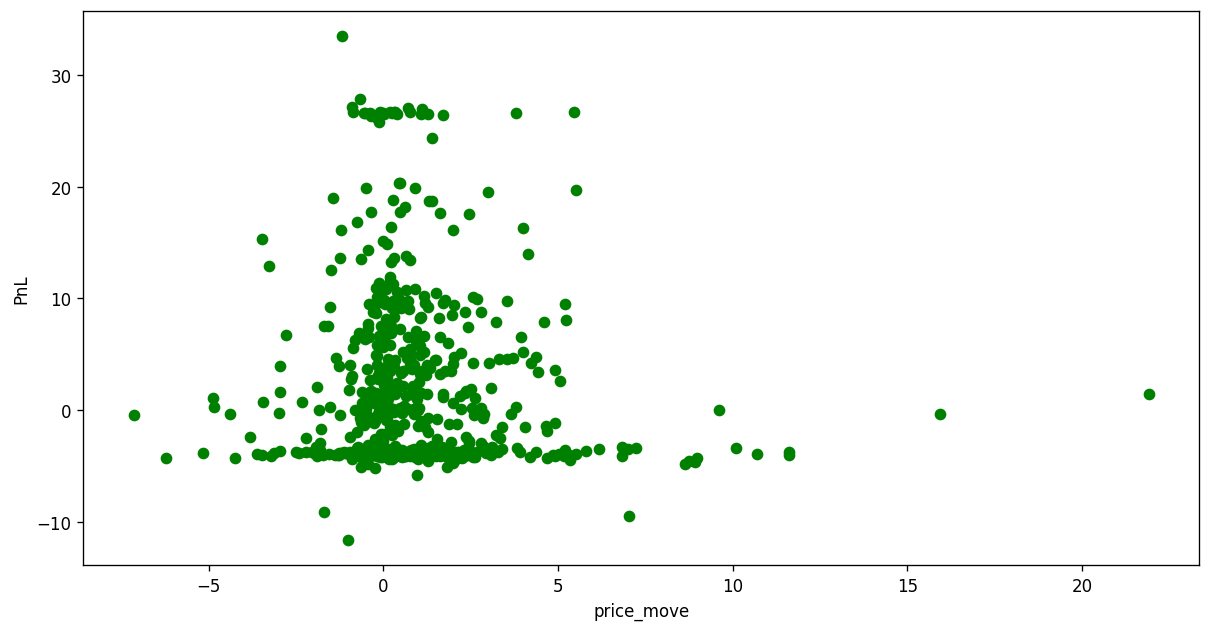

In [43]:
plt.scatter(long_trades['price_move'], long_trades['PnL'], color='green')
plt.xlabel("price_move")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

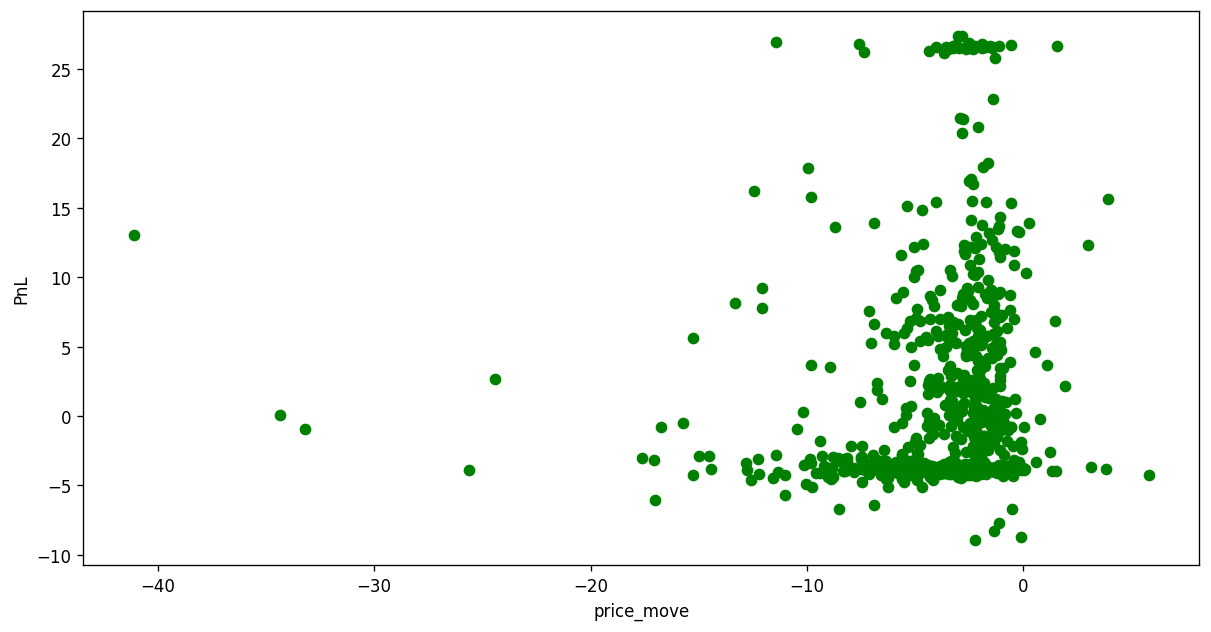

In [44]:
plt.scatter(short_trades['price_move'], short_trades['PnL'], color='green')
plt.xlabel("price_move")
plt.ylabel("PnL")

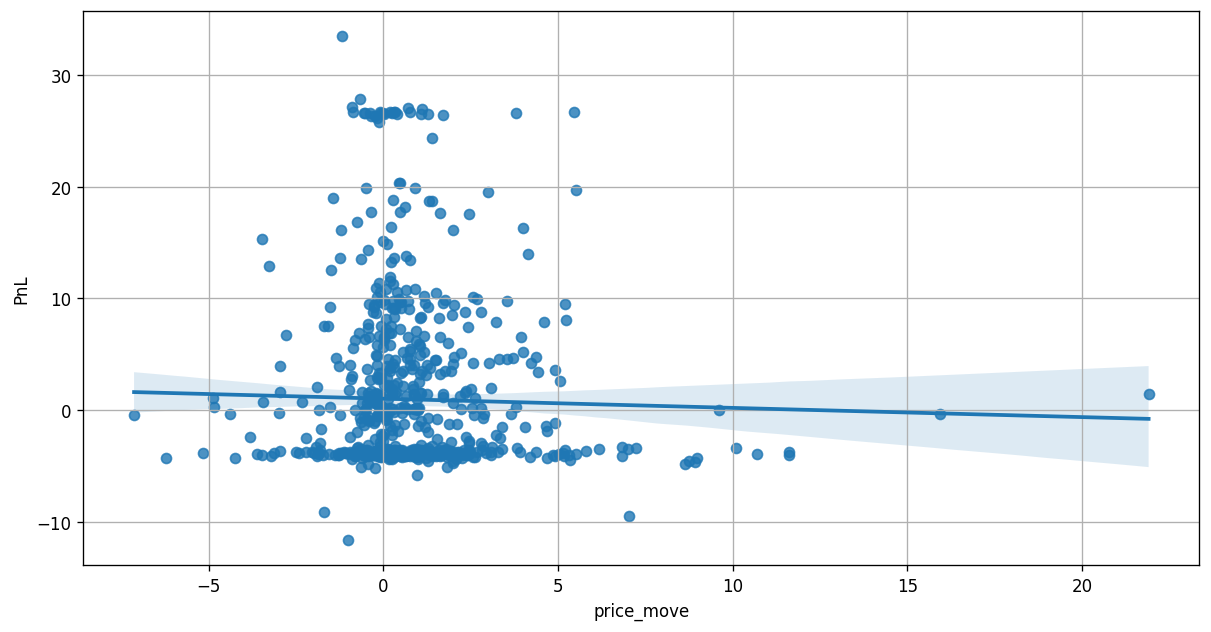

In [45]:
sns.regplot(x=long_trades['price_move'], y=long_trades['PnL'])
plt.grid(True)

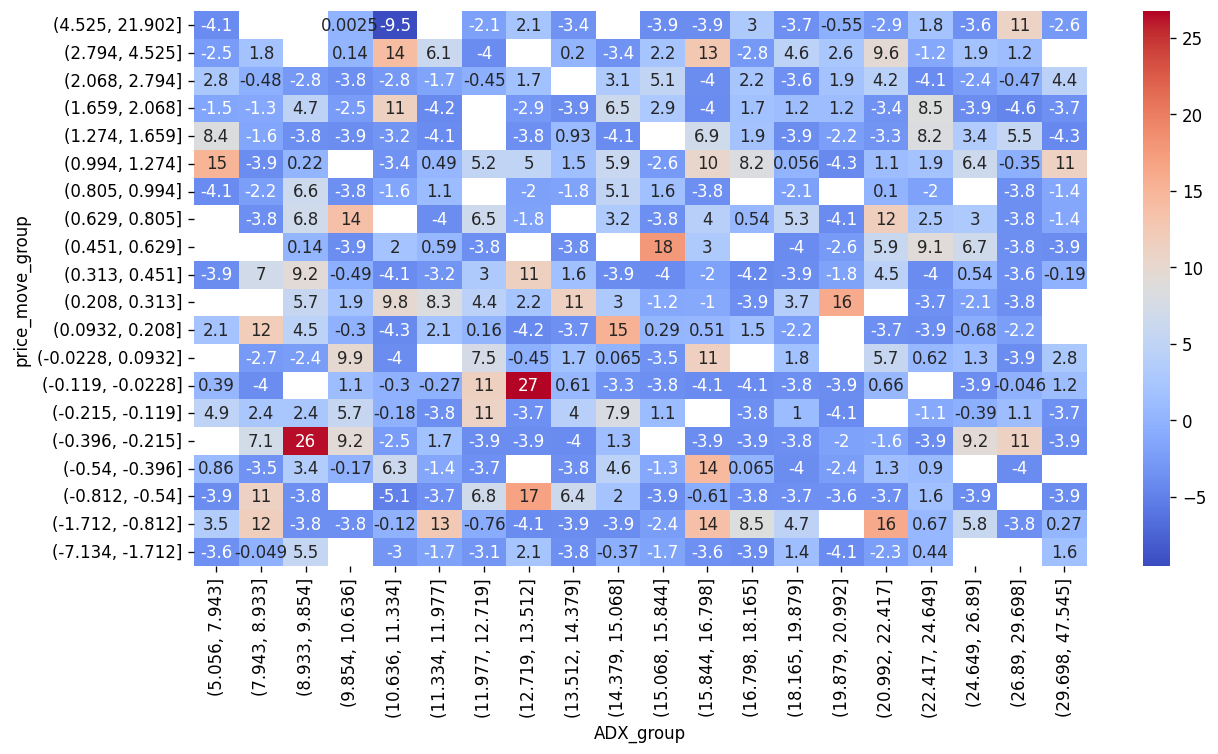

In [46]:
grpd_pa = long_trades.groupby(['price_move_group', 'ADX_group'])[['PnL']]
irs_pa = grpd_pa.mean().reset_index()
sns.heatmap(
    irs_pa.pivot(index='price_move_group', columns='ADX_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

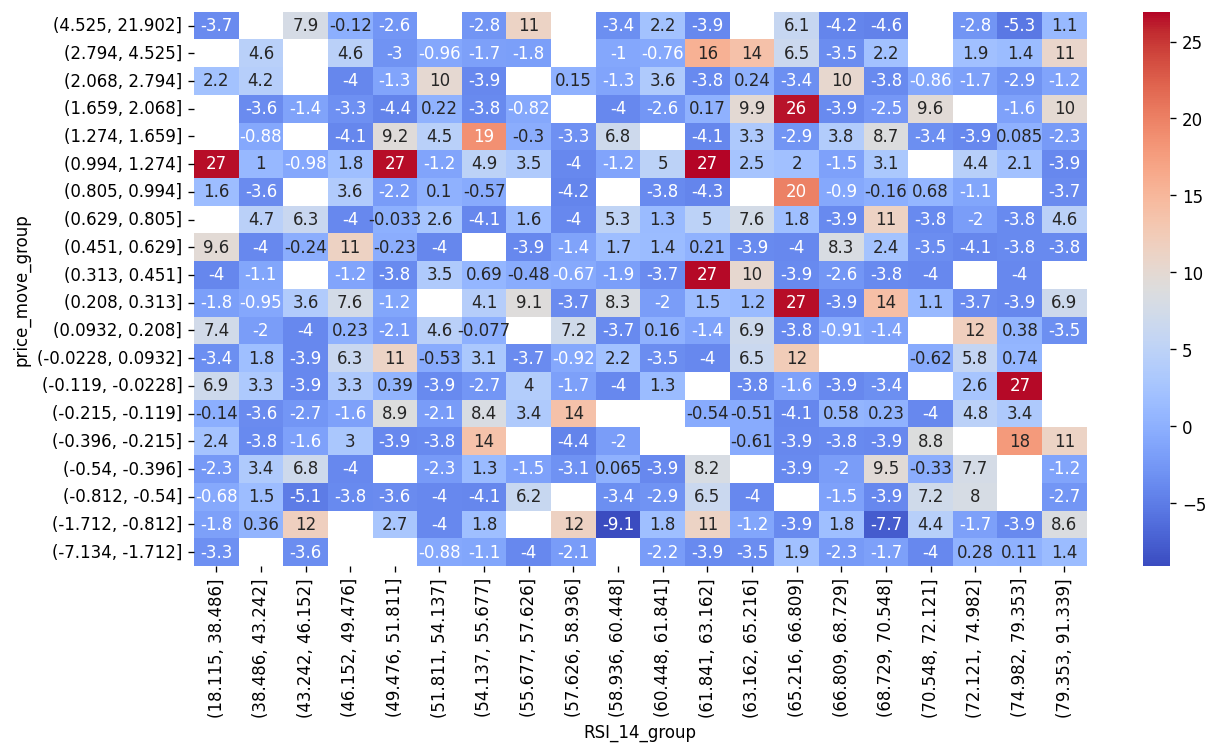

In [47]:
grpd_prsi = long_trades.groupby(['price_move_group', 'RSI_14_group'])[['PnL']]
irs_prsi = grpd_prsi.mean().reset_index()
sns.heatmap(
    irs_prsi.pivot(index='price_move_group', columns='RSI_14_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

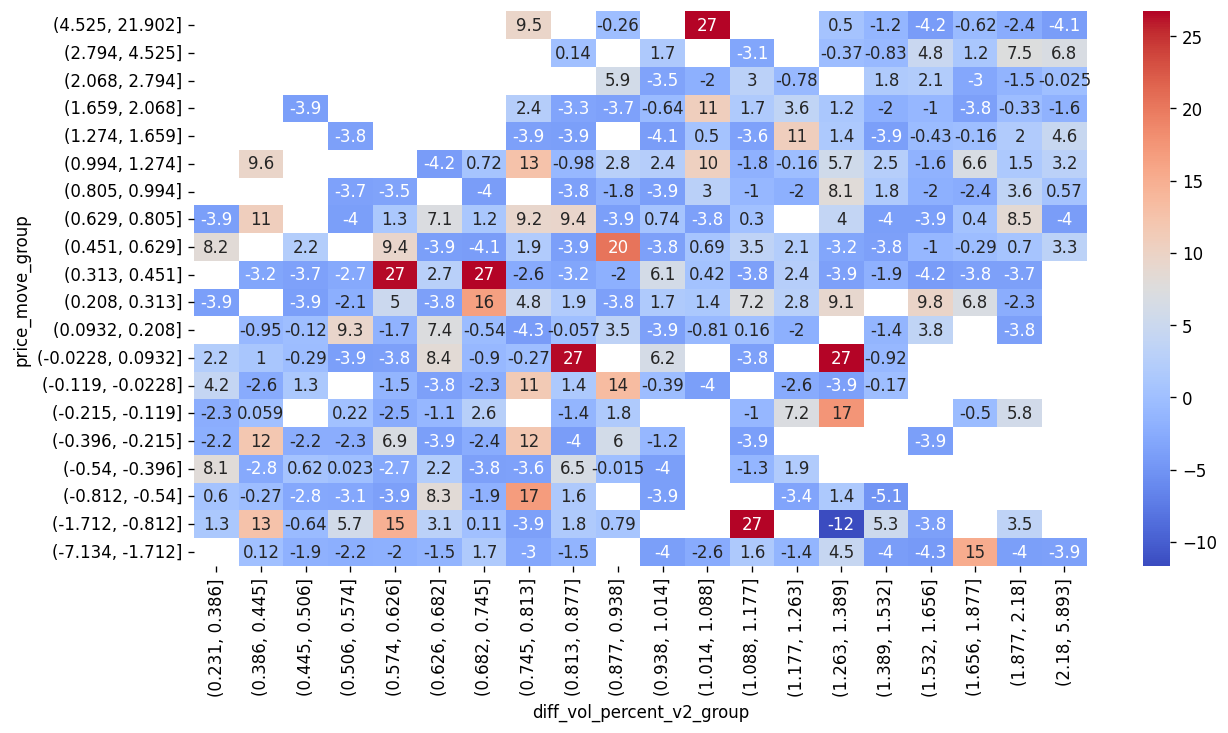

In [70]:
group_pmdv = long_trades.groupby(['price_move_group', 'diff_vol_percent_v2_group'])[['PnL']]
irs_pmdv = group_pmdv.mean().reset_index()
sns.heatmap(
    irs_pmdv.pivot(index='price_move_group', columns='diff_vol_percent_v2_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

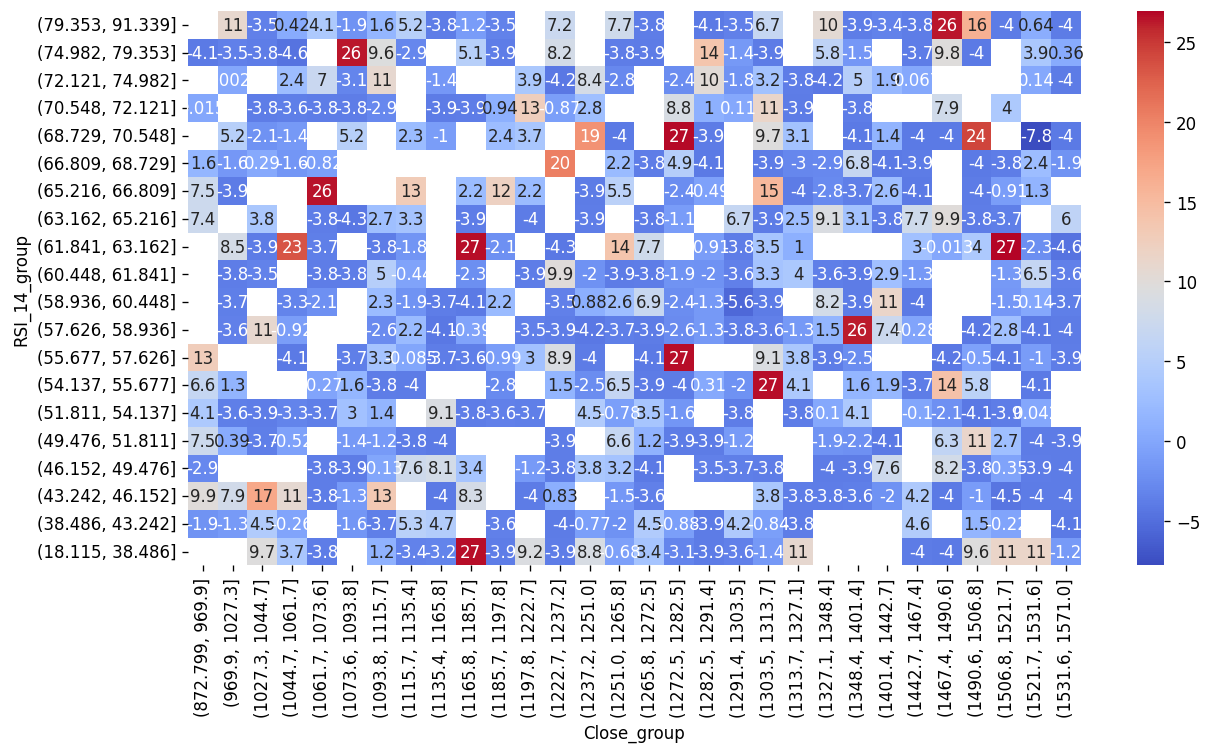

In [49]:
grpd_rc = long_trades.groupby(['RSI_14_group', 'Close_group'])[['PnL']]
irs_rc = grpd_rc.mean().reset_index()
sns.heatmap(
    irs_rc.pivot(index='RSI_14_group', columns='Close_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

Text(0, 0.5, 'PnL')

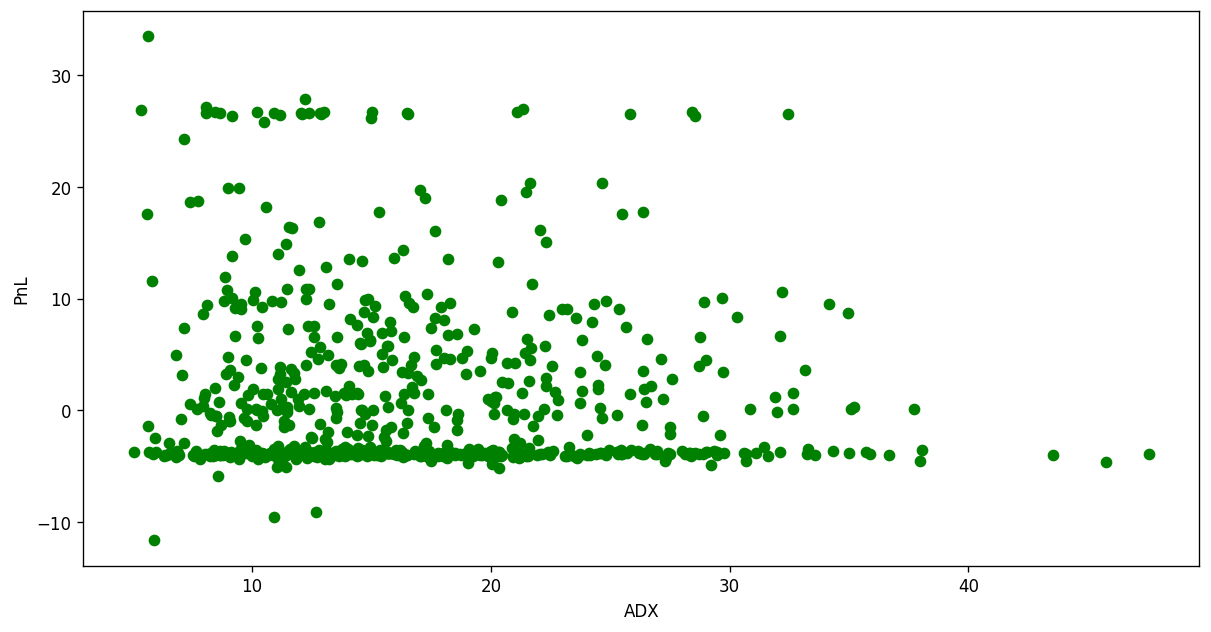

In [50]:
plt.scatter(long_trades['ADX'], long_trades['PnL'], color='green')
plt.xlabel("ADX")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

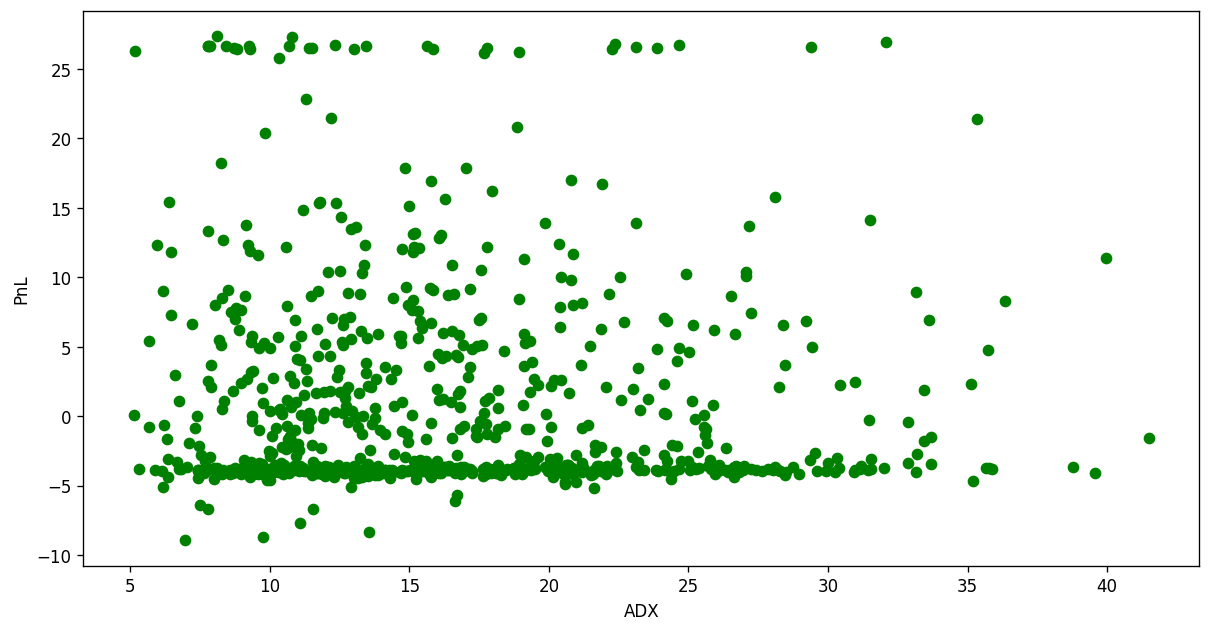

In [51]:
plt.scatter(short_trades['ADX'], short_trades['PnL'], color='green')
plt.xlabel("ADX")
plt.ylabel("PnL")

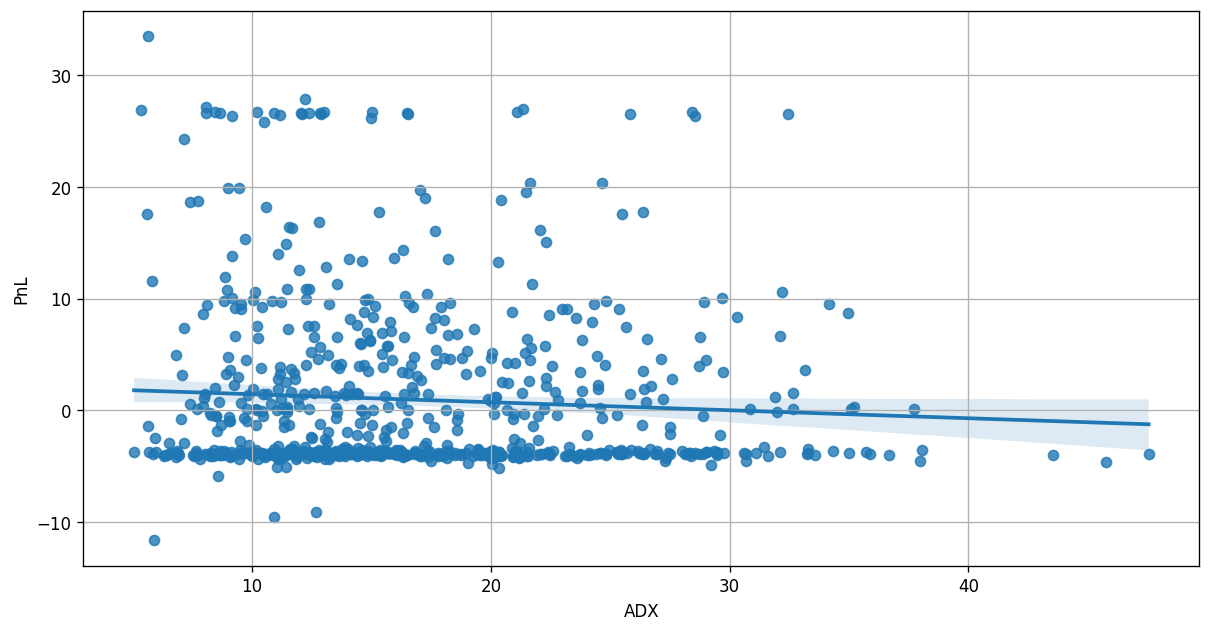

In [52]:
sns.regplot(x=long_trades['ADX'], y=long_trades['PnL'])
plt.grid(True)

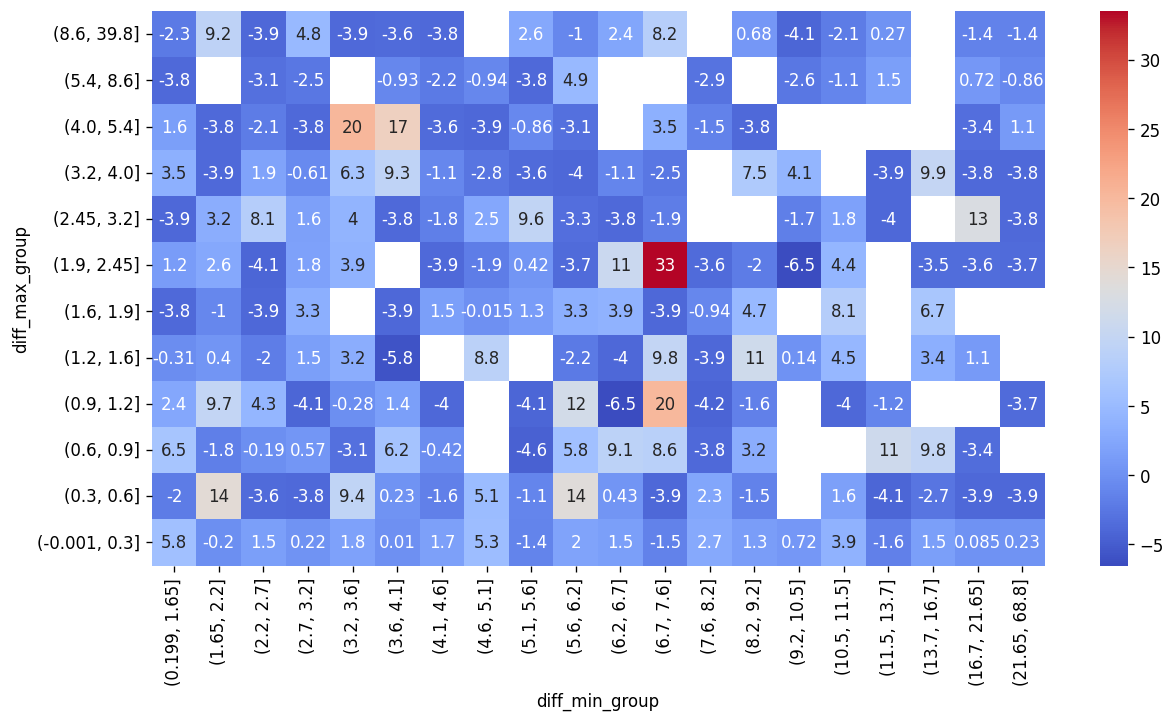

In [53]:
long_trades['diff_max'] = long_trades['max_in_range'] - long_trades['Close']
long_trades['diff_min'] = long_trades['Close'] - long_trades['min_in_range']
long_trades['diff_max_group'] = pd.qcut(long_trades['diff_max'], 20, duplicates='drop')
long_trades['diff_min_group'] = pd.qcut(long_trades['diff_min'], 20)
grpd_dmm = long_trades.groupby(['diff_max_group', 'diff_min_group'])[['PnL']]
irs_dmm = grpd_dmm.mean().reset_index()
sns.heatmap(
    irs_dmm.pivot(index='diff_max_group', columns='diff_min_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

Text(0, 0.5, 'PnL')

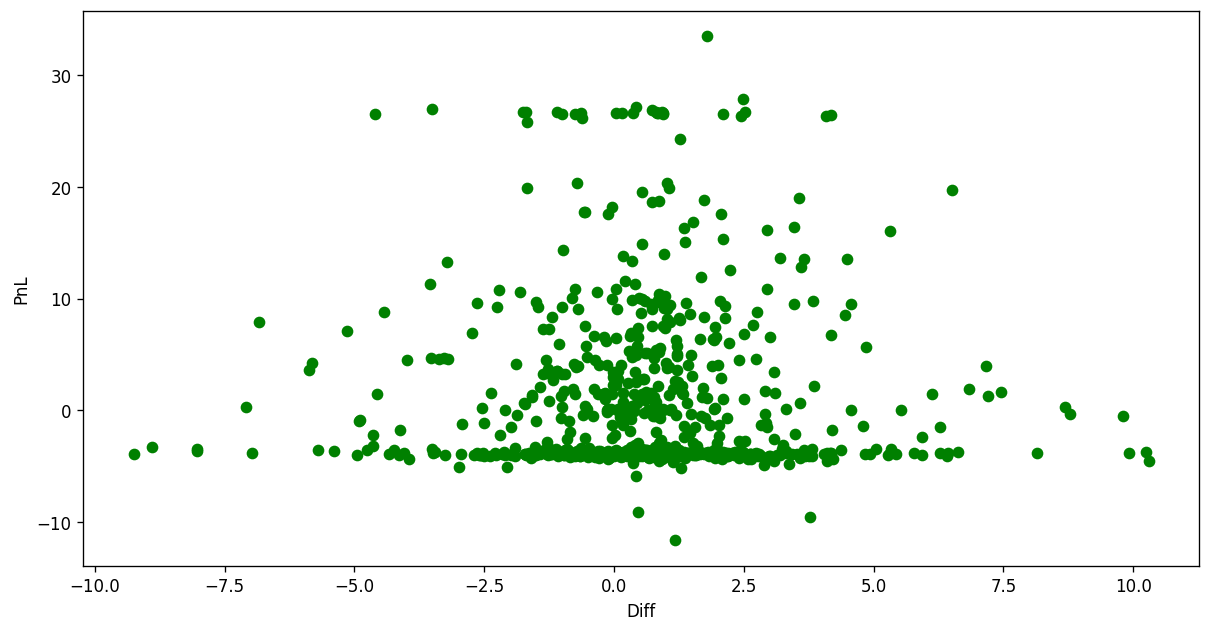

In [54]:
long_trades['diff_ema_x'] = long_trades['ema_superfast'] - long_trades['ema_fast']
plt.scatter(long_trades['diff_ema_x'], long_trades['PnL'], color='green')
plt.xlabel("Diff")
plt.ylabel("PnL")

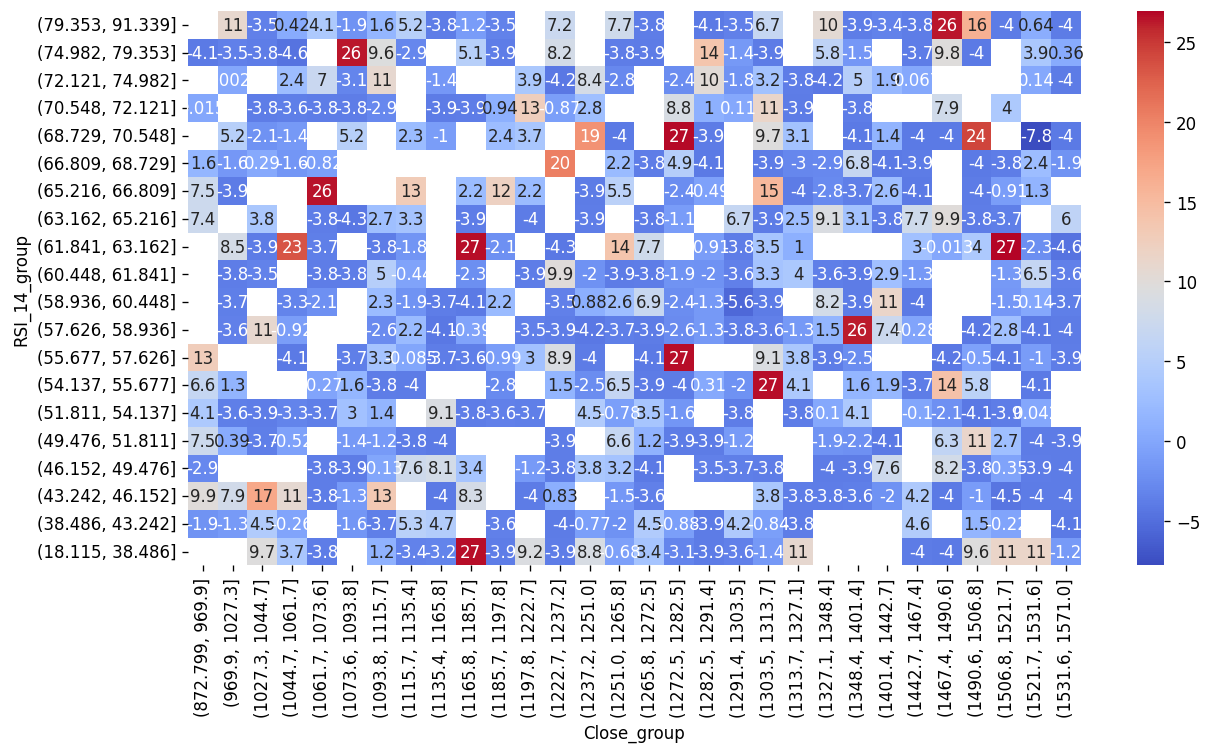

In [55]:
grpd_rc = long_trades.groupby(['RSI_14_group', 'Close_group'])[['PnL']]
irs_rc = grpd_rc.mean().reset_index()
sns.heatmap(
    irs_rc.pivot(index='RSI_14_group', columns='Close_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

Text(0, 0.5, 'PnL')

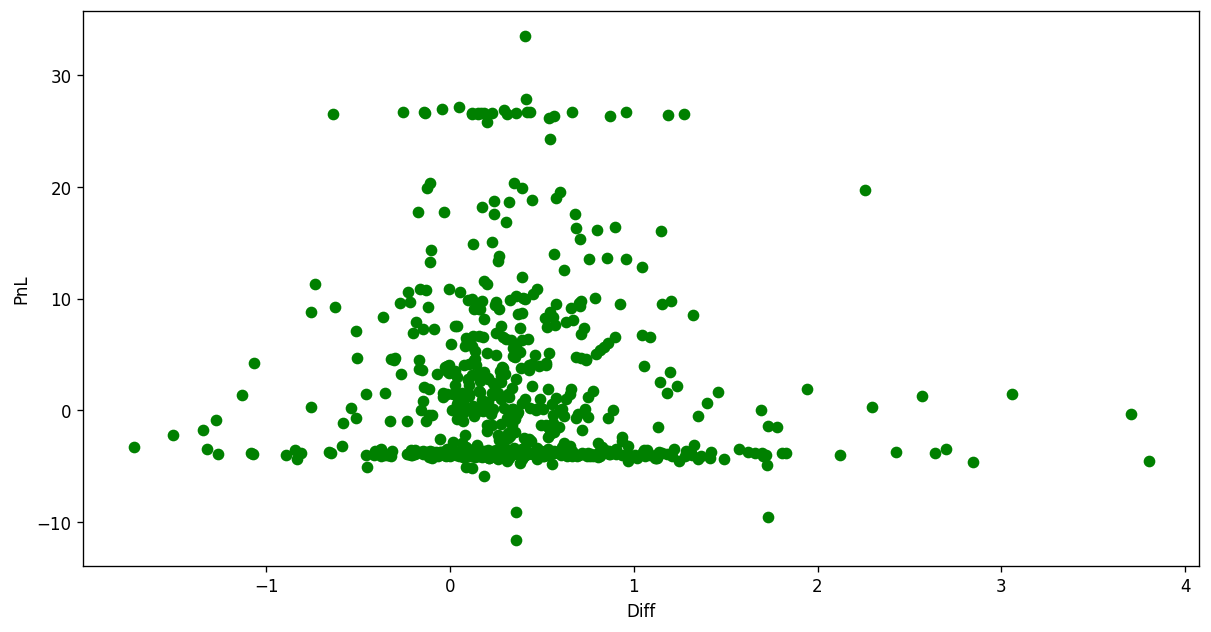

In [56]:
long_trades['diff_ema_fast'] = long_trades['ema_fast'] - long_trades['ema_fast_s1']
plt.scatter(long_trades['diff_ema_fast'], long_trades['PnL'], color='green')
plt.xlabel("Diff")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

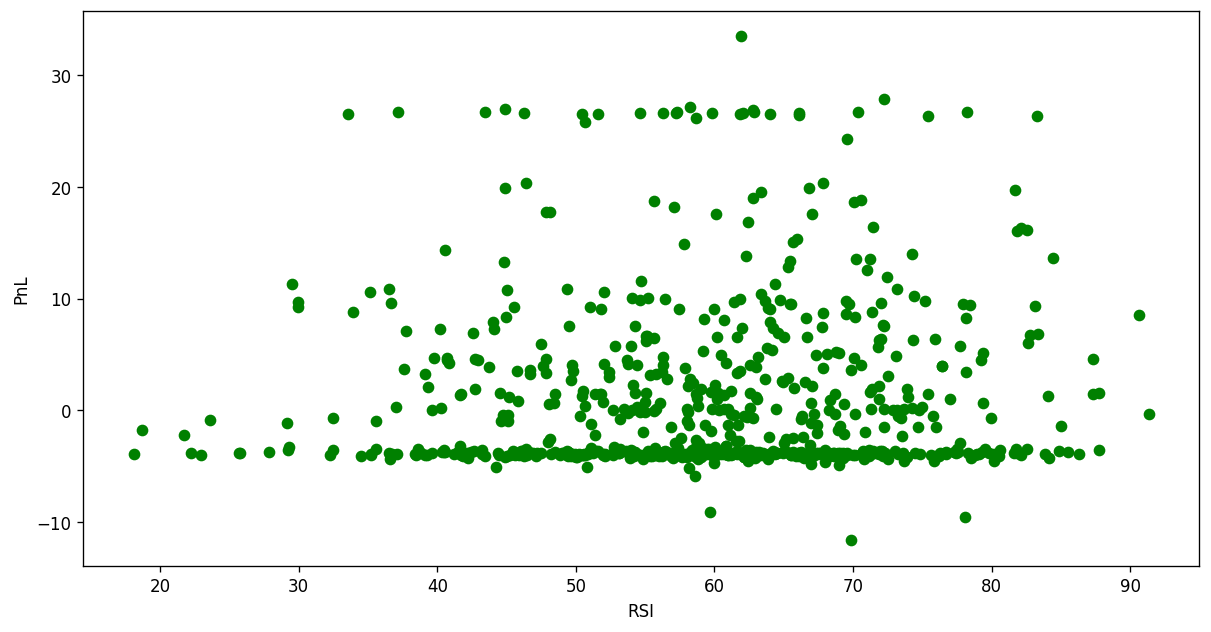

In [57]:
plt.scatter(long_trades['RSI_14'], long_trades['PnL'], color='green')
plt.xlabel("RSI")
plt.ylabel("PnL")

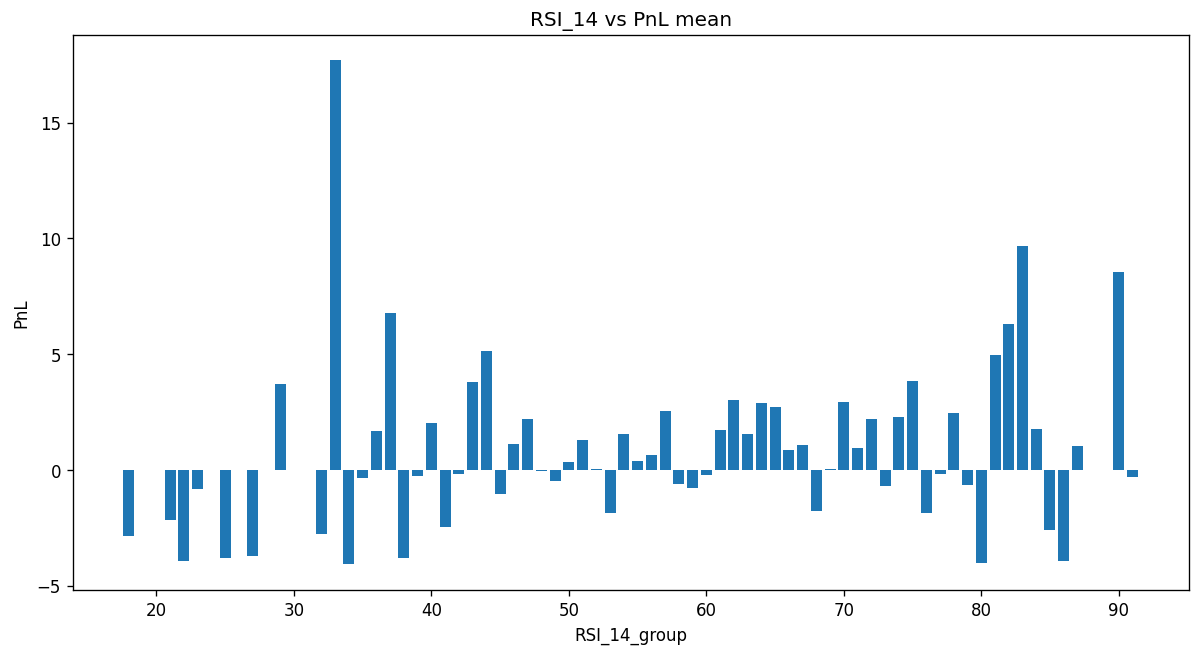

In [58]:
import math
long_trades['RSI_14_group'] = long_trades.apply(lambda r: math.floor(r['RSI_14']), axis=1)
gr_macdg = long_trades.groupby(['RSI_14_group'])[['PnL']]
gr_macdg_rs = gr_macdg.mean().reset_index()
plt.bar(gr_macdg_rs['RSI_14_group'], gr_macdg_rs['PnL'])
plt.title('RSI_14 vs PnL mean')
plt.xlabel('RSI_14_group')
plt.ylabel('PnL')
plt.show()

Text(0, 0.5, 'PnL')

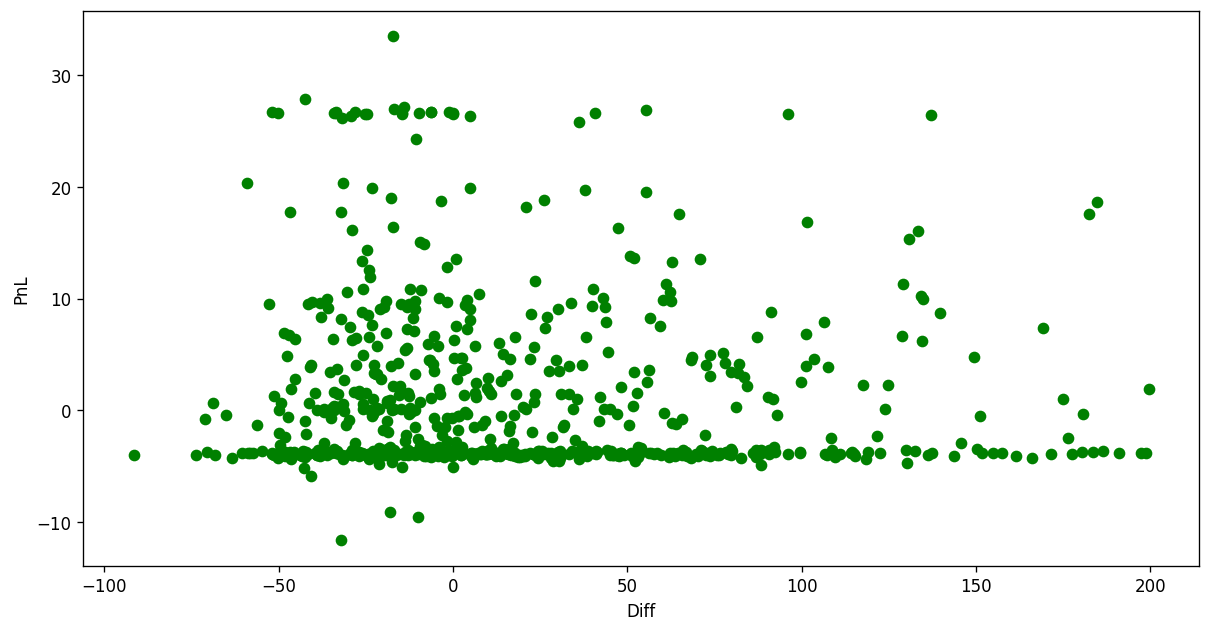

In [59]:
diff_v = long_trades[long_trades['diff_vol_percent'] < 200]
plt.scatter(diff_v['diff_vol_percent'], diff_v['PnL'], color='green')
plt.xlabel("Diff")
plt.ylabel("PnL")

Text(0, 0.5, 'PnL')

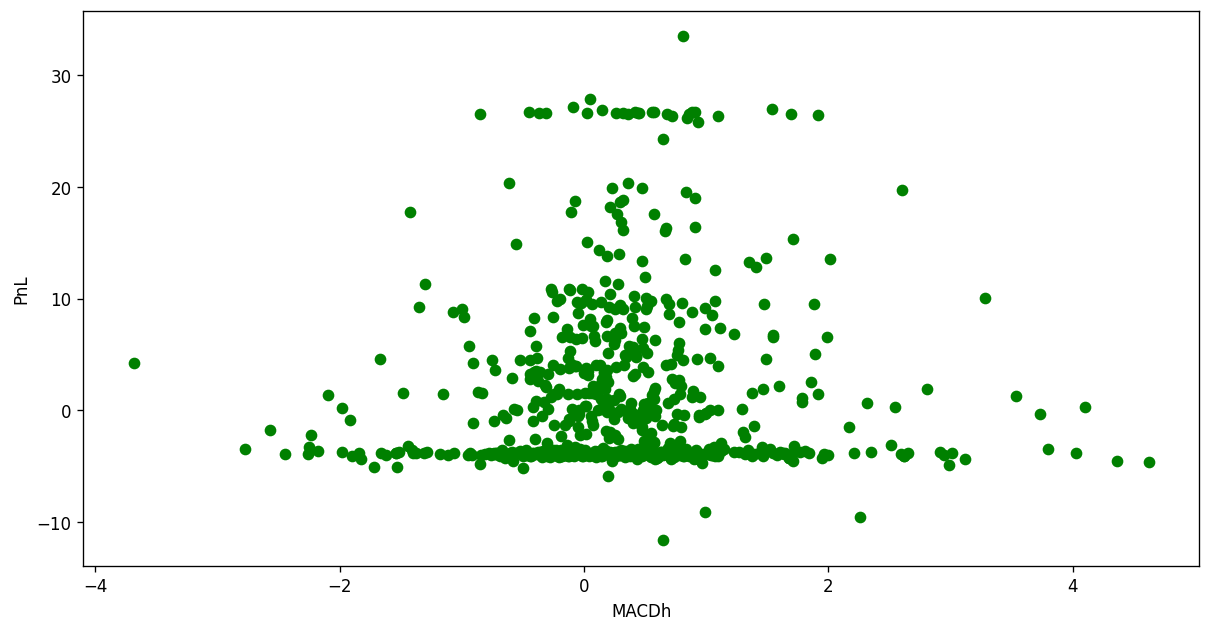

In [60]:
plt.scatter(long_trades['MACDh'], long_trades['PnL'], color='green')
plt.xlabel("MACDh")
plt.ylabel("PnL")

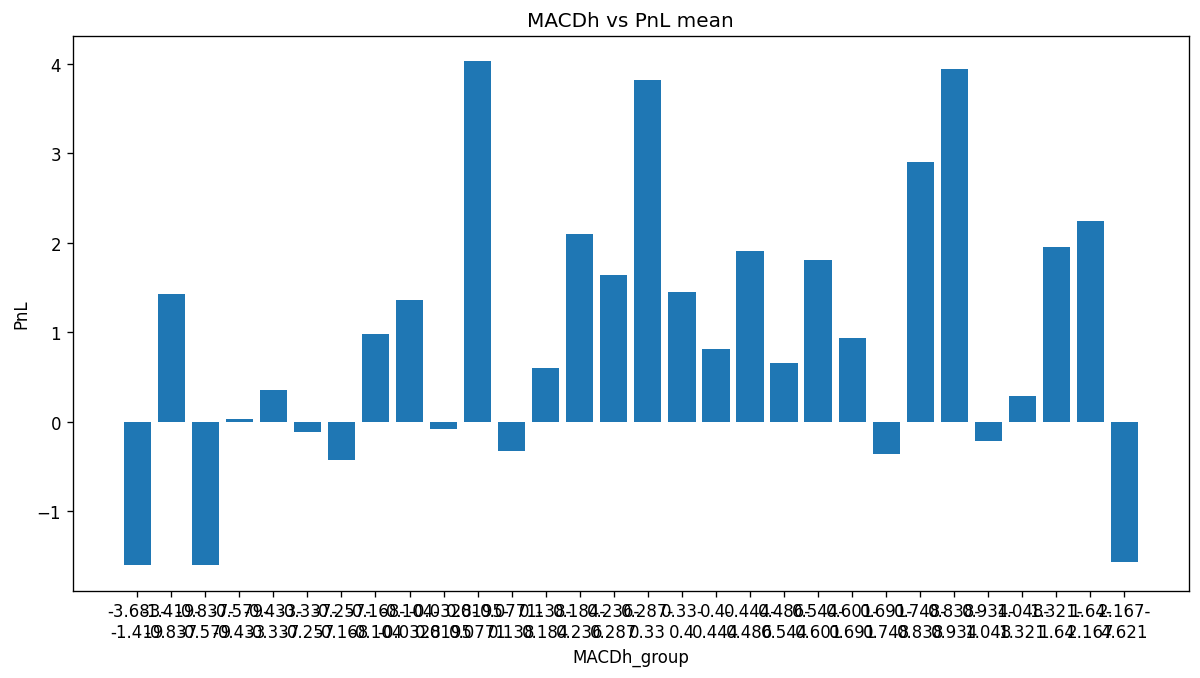

In [61]:
long_trades['MACDh_group'] = pd.qcut(long_trades['MACDh'], 30)
gr_macdg = long_trades.groupby(['MACDh_group'])[['PnL']]
gr_macdg_rs = gr_macdg.mean().reset_index()
gr_macdg_rs['MACDh_group_str'] = gr_macdg_rs.apply(lambda r: f"{r['MACDh_group'].left}-\n{r['MACDh_group'].right}", axis=1)
plt.bar(gr_macdg_rs['MACDh_group_str'], gr_macdg_rs['PnL'])
plt.title('MACDh vs PnL mean')
plt.xlabel('MACDh_group')
plt.ylabel('PnL')
plt.show()

Text(0, 0.5, 'PnL')

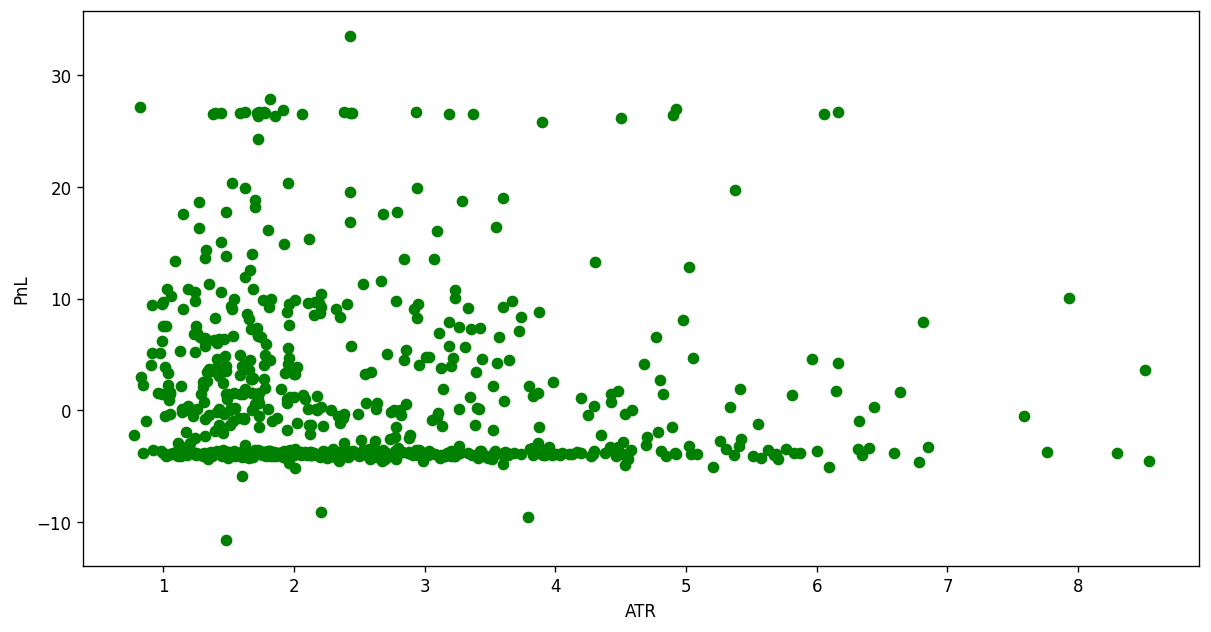

In [62]:
plt.scatter(long_trades['ATR_20'], long_trades['PnL'], color='green')
plt.xlabel("ATR")
plt.ylabel("PnL")

In [63]:
long_trades['RSI_14_group'] = pd.qcut(long_trades['RSI_14'], 20)
long_trades['RSI_20_group'] = pd.qcut(long_trades['RSI_20'], 20)

In [64]:
long_trades

Size  EntryBar  ExitBar  EntryPrice  ExitPrice       PnL  ReturnPct  \
3        1        98      131   912.07354      913.5   1.42646   0.001564   
4        1       224      233   906.97201      910.5   3.52799   0.003890   
5        1       236      334   915.07444      924.6   9.52556   0.010410   
10       1       582      608   926.77795      933.1   6.32205   0.006822   
12       1       651      690   937.58119      944.2   6.61881   0.007059   
...    ...       ...      ...         ...        ...       ...        ...   
1613     1     53650    53768  1309.49273     1324.8  15.30727   0.011689   
1615     1     53854    53899  1324.69729     1342.9  18.20271   0.013741   
1616     1     53922    53950  1340.60206     1342.1   1.49794   0.001117   
1621     1     54043    54157  1328.39840     1336.6   8.20160   0.006174   
1622     1     54199    54205  1345.30347     1343.3  -2.00347  -0.001489   

               EntryTime            ExitTime   Tag  ...         ADX_group  \
3    2020-11-04 10:20:00 2020-11-04 14:30:00  None  ...    (7.943, 8.933]   
4    2020-11-06 13:45:00 2020-11-06 14:30:00  None  ...  (14.379, 15.068]   
5    2020-11-09 09:05:00 2020-11-10 14:25:00  None  ...  (12.719, 13.512]   
10   2020-11-17 14:00:00 2020-11-18 10:30:00  None  ...  (14.379, 15.068]   
12   2020-11-19 09:50:00 2020-11-19 14:30:00  None  ...    (8.933, 9.854]   
...                  ...                 ...   ...  ...               ...   
1613 2025-01-17 09:20:00 2025-01-21 10:40:00  None  ...    (8.933, 9.854]   
1615 2025-01-23 09:20:00 2025-01-23 14:30:00  None  ...   (9.854, 10.636]   
1616 2025-01-24 10:45:00 2025-01-24 14:30:00  None  ...   (24.649, 26.89]   
1621 2025-02-04 13:45:00 2025-02-07 09:05:00  None  ...  (13.512, 14.379]   
1622 2025-02-07 14:00:00 2025-02-07 14:30:00  None  ...  (15.844, 16.798]   

      diff_vol_percent_v2_group  diff_max  diff_min  diff_max_group  \
3                (1.656, 1.877]       0.0       4.8   (-0.001, 0.3]   
4                (1.088, 1.177]       1.1       3.4      (0.9, 1.2]   
5                (0.745, 0.813]       0.6       7.9      (0.3, 0.6]   
10               (1.263, 1.389]       0.6       6.7      (0.3, 0.6]   
12               (0.386, 0.445]       0.0       1.6   (-0.001, 0.3]   
...                         ...       ...       ...             ...   
1613             (1.656, 1.877]       3.6      14.0      (3.2, 4.0]   
1615             (0.626, 0.682]       0.4       4.7      (0.3, 0.6]   
1616             (0.506, 0.574]       1.6       2.4      (1.2, 1.6]   
1621             (0.682, 0.745]       1.6       3.4      (1.2, 1.6]   
1622             (0.626, 0.682]       2.5       7.1     (2.45, 3.2]   

      diff_min_group diff_ema_x  diff_ema_fast       MACDh_group  \
3         (4.6, 5.1]   0.538828       0.316198    (0.236, 0.287]   
4         (3.2, 3.6]  -1.095932      -0.016886  (0.0195, 0.0771]   
5         (7.6, 8.2]   0.998773       0.576963    (0.691, 0.748]   
10        (6.2, 6.7]   1.190119       0.331381    (0.544, 0.601]   
12     (0.199, 1.65]   0.306334       0.123619   (0.0771, 0.138]   
...              ...        ...            ...               ...   
1613    (13.7, 16.7]   2.092295       0.707848     (1.64, 2.167]   
1615      (4.6, 5.1]  -0.035391       0.172647    (0.184, 0.236]   
1616      (2.2, 2.7]  -0.316390       0.019470  (-0.257, -0.168]   
1621      (3.2, 3.6]   1.011974       0.187418  (0.0195, 0.0771]   
1622      (6.7, 7.6]   1.458565       0.315586    (0.544, 0.601]   

          RSI_20_group  
3      (63.48, 64.987]  
4     (42.571, 46.021]  
5     (60.452, 61.907]  
10     (61.907, 63.48]  
12    (53.995, 55.745]  
...                ...  
1613   (61.907, 63.48]  
1615  (53.995, 55.745]  
1616  (52.493, 53.995]  
1621   (57.05, 58.354]  
1622   (63.48, 64.987]  

[751 rows x 72 columns]

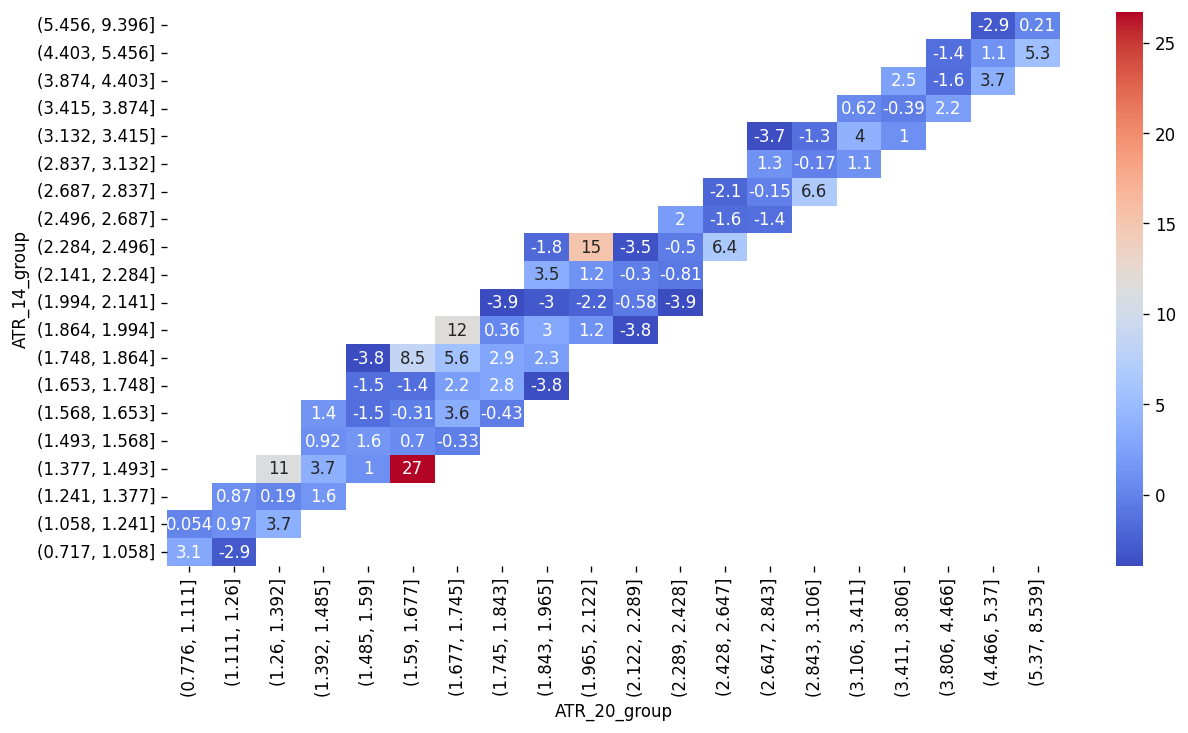

In [65]:
long_trades['ATR_14_group'] = pd.qcut(long_trades['ATR_14'], 20)
long_trades['ATR_20_group'] = pd.qcut(long_trades['ATR_20'], 20)
# group return by atr
gr_atr = long_trades.groupby(['ATR_14_group', 'ATR_20_group'])[['PnL']]
gr_atr_rs = gr_atr.mean().reset_index()
sns.heatmap(
    gr_atr_rs.pivot(index='ATR_14_group', columns='ATR_20_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

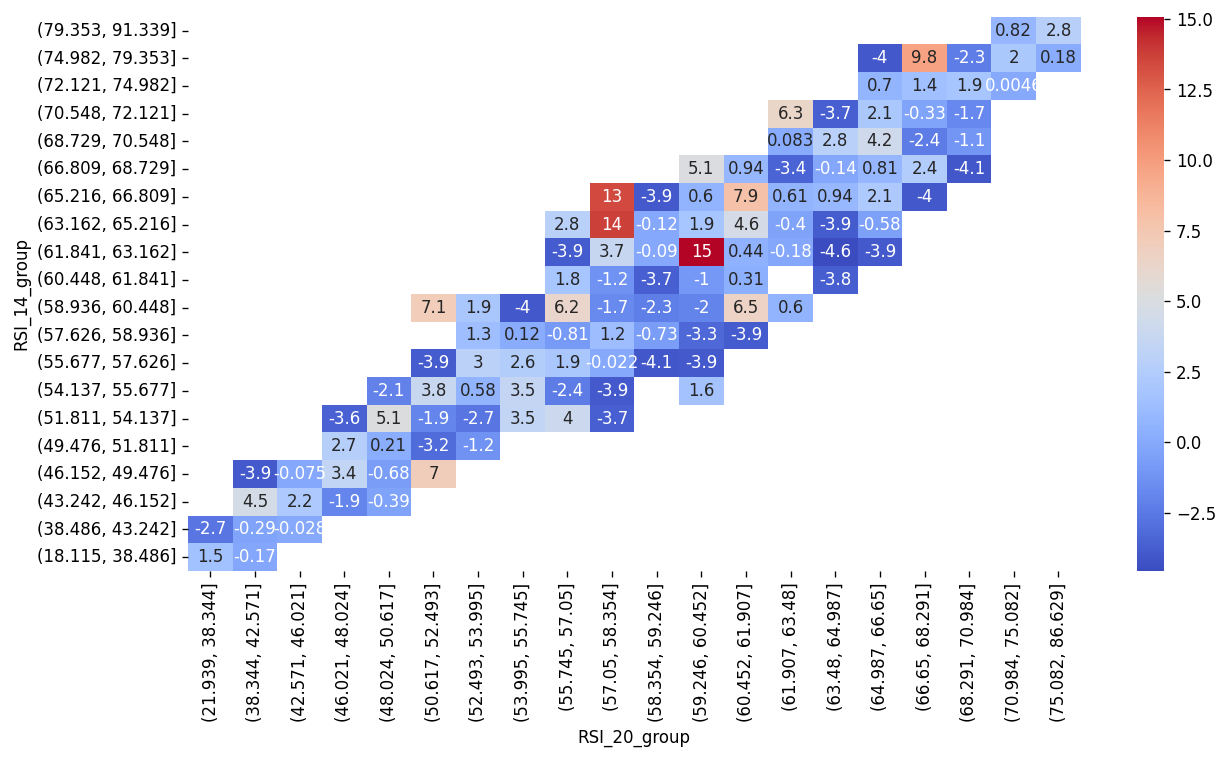

In [66]:
grpd = long_trades.groupby(['RSI_14_group', 'RSI_20_group'])[['PnL']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='RSI_14_group', columns='RSI_20_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

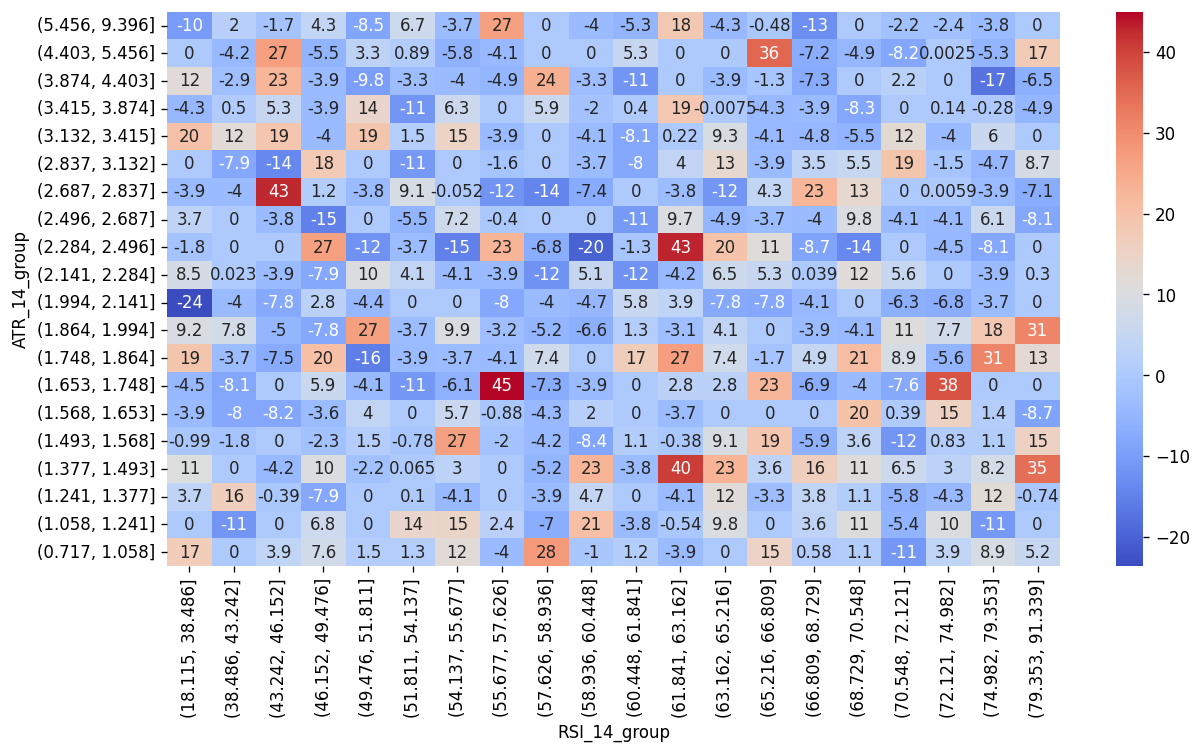

In [67]:
# group return by atr & rsi
gr_ar = long_trades.groupby(['ATR_14_group', 'RSI_14_group'])[['PnL']]
gr_ar_rs = gr_ar.sum().reset_index()
sns.heatmap(
    gr_ar_rs.pivot(index='ATR_14_group', columns='RSI_14_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);

In [68]:
long_trades['diff_vol_group'] = pd.qcut(long_trades['diff_vol_percent'], 20)

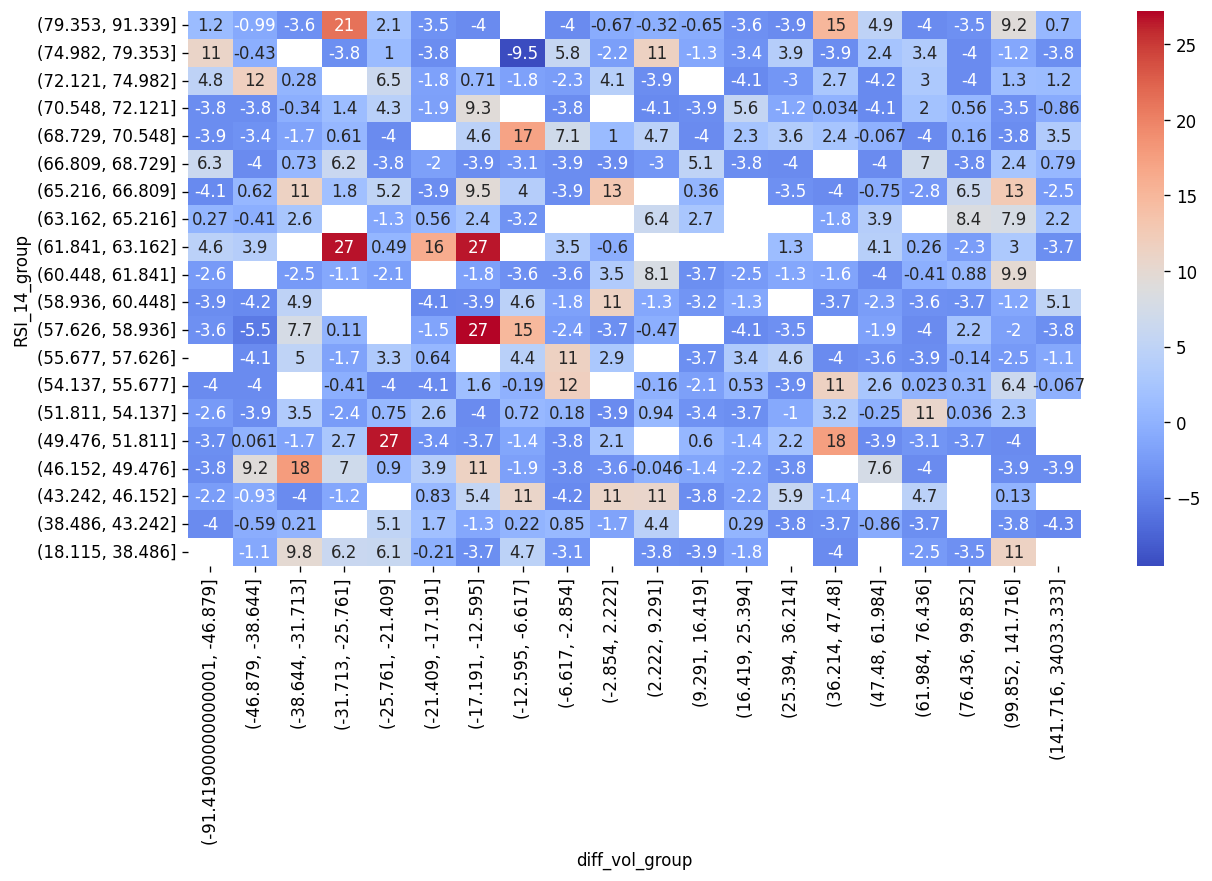

In [69]:
# group return of rsi & diff vol
gr_rd = long_trades.groupby(['RSI_14_group', 'diff_vol_group'])[['PnL']]
gr_rd_rs = gr_rd.mean().reset_index()
sns.heatmap(
    gr_rd_rs.pivot(index='RSI_14_group', columns='diff_vol_group', values='PnL').sort_index(ascending=False),
    cmap = 'coolwarm',
    annot=True);